In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import healpy as hp
import rubin_sim.maf as maf

In [75]:
families = maf.archive.get_family_descriptions('runs_v2.2.json')
family_list = families.index.values
summary_source = 'summary_2022_10_25.csv'
summaries = maf.get_metric_summaries(summary_source=summary_source)
metrics_source = 'metric_sets.json'
metric_sets = maf.get_metric_sets(metrics_source)

# list the metric sets
msets = list(metric_sets.groupby('metric set').first().index)

In [27]:
draft_runs = ['draft_connected_v2.99_10yrs', 
              'dd6_v2.99_10yrs', 
              'low_gp_v2.99_10yrs', 
              'roll_early_v2.99_10yrs']
ddir = '/Users/lynnej/opsim/v2.9'

In [28]:
outDir = 'draft_temp'
nside=64
bundles = {}
for r in draft_runs:
    opsdb = os.path.join(ddir, r + '.db')
    metric = maf.CountMetric(col='observationStartMJD', metricName='Nvisits')
    s = maf.HealpixSlicer(nside=nside)
    bundles[r] = maf.MetricBundle(metric, s, None, runName=r)
    g = maf.MetricBundleGroup({r: bundles[r]}, opsdb, outDir=outDir)
    g.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


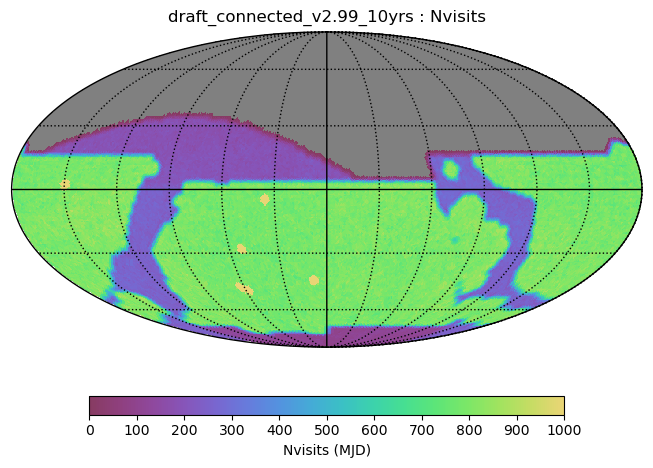

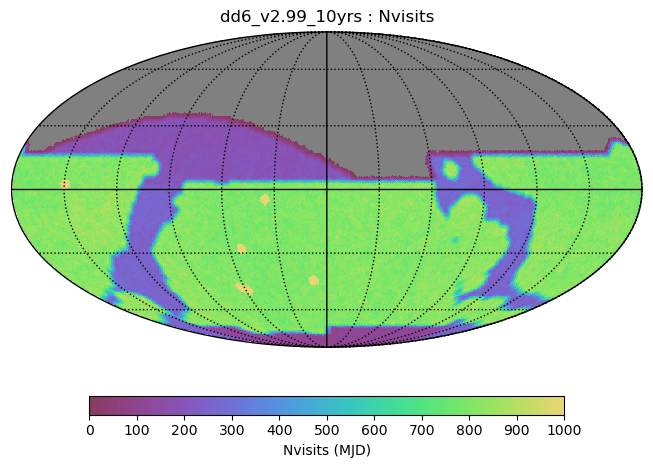

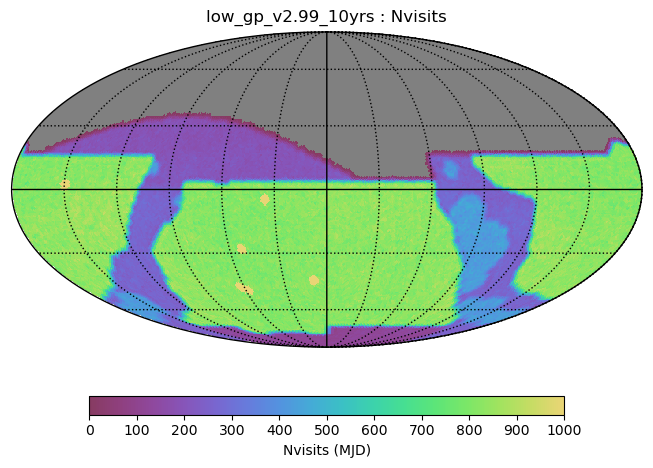

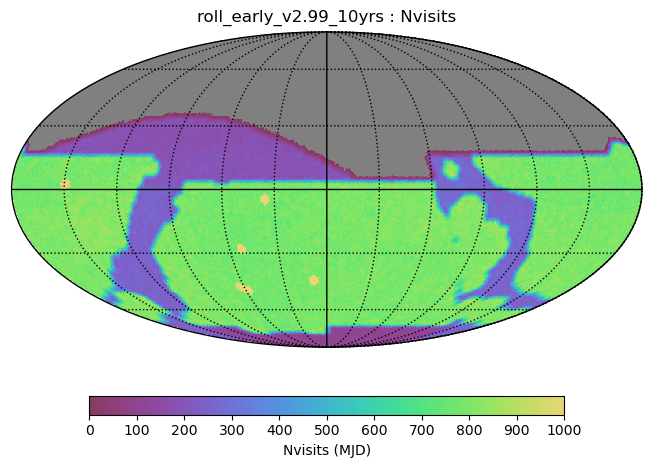

In [30]:
ph = maf.PlotHandler(outDir=outDir, thumbnail=False, figformat='png')
for r in draft_runs:
    plotDict = {'colorMin': 0, 'colorMax': 1000}
    ph.setMetricBundles([bundles[r]])
    ph.plot(maf.HealpixSkyMap(), plotDicts=plotDict)

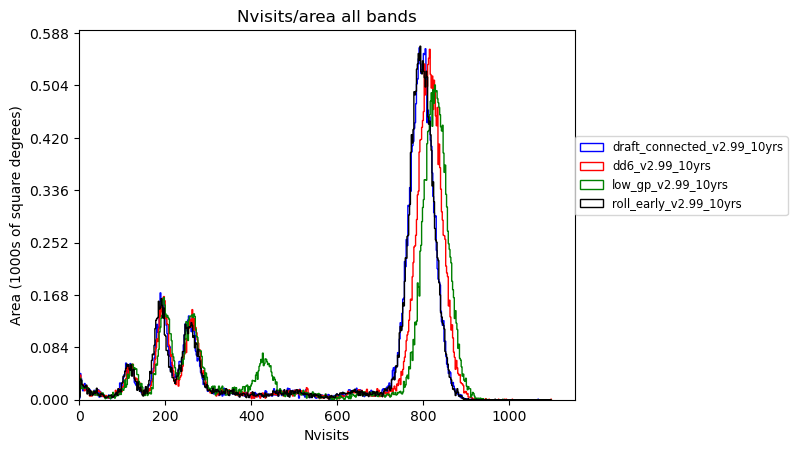

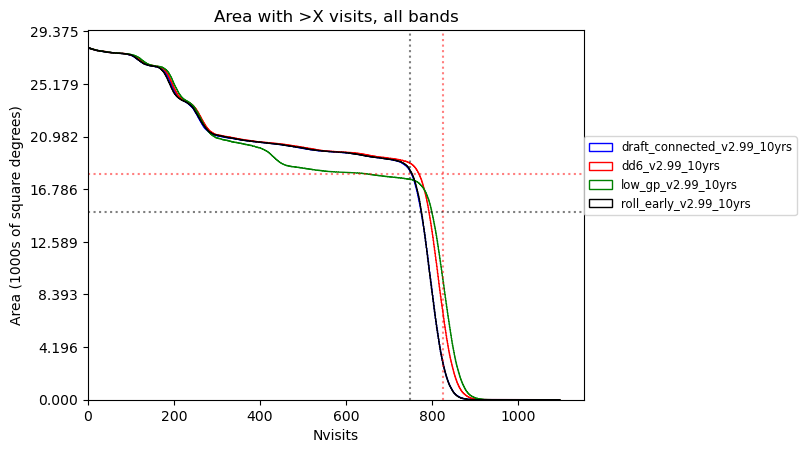

In [51]:
# Area / Nvisits 

draft_colors = dict(zip(draft_runs, ['b', 'r', 'g', 'k']))

plotDicts = []
for r in draft_runs:
    plotDicts.append({'color': draft_colors[r], 
                      'xMin': 0,
                      'bins':np.arange(0, 1100, 2),
                     'legendloc': (1.0, 0.5),
                     'title': "Nvisits/area all bands"})
ph.setMetricBundles(bundles)
ph.plot(maf.HealpixHistogram(), plotDicts=plotDicts)


plotDicts = []
plotDicts = []
for r in draft_runs:
    plotDicts.append({'color': draft_colors[r], 
                      'xMin': 0,
                      'cumulative': -1,
                      'bins':np.arange(0, 1100, 1),
                     'legendloc': (1.0, 0.5),
                     'title': "Area with >X visits, all bands"})
ph.setMetricBundles(bundles)
ph.plot(maf.HealpixHistogram(), plotDicts=plotDicts)
plt.axvline(750, color='k', linestyle=':', alpha=0.5)
plt.axvline(825, color='r', linestyle=':', alpha=0.5)
yscale = hp.nside2pixarea(s.nside, degrees=True) / 1000.0
plt.axhline(18/yscale, color='r', linestyle=':', alpha=0.5)
plt.axhline(15/yscale, color='k', linestyle=':', alpha=0.5)

In [71]:
# Pull down target footprint information
import requests
rooturl = 'https://raw.githubusercontent.com/lsst-sims/sims_featureScheduler_runs3.0/main/draft/'
for file in ['draft_connected.py', 'make_ddf_survey.py', 'gen_long_gaps.py']:
    r = requests.get(rooturl+file, allow_redirects=True)
    with open(file, 'w') as f:
        f.write(r.content.decode())
    
from draft_connected import Sky_area_generator_galplane
sky = Sky_area_generator_galplane(nside=nside, smc_radius=4, lmc_radius=6)
footprints, labels = sky.return_maps(
    bulge_ratios={"u": 0.23, "g": 0.43, "r": 1.22, "i": 1.17, "z": 0.82, "y": 0.65},
    dusty_plane_ratios={
        "u": 0.08,
        "g": 0.12,
        "r": 0.31,
        "i": 0.31,
        "z": 0.28,
        "y": 0.22,
    },
)

total_fp = np.zeros(len(footprints['r']))
for f in 'ugrizy':
    total_fp += footprints[f]
#hp.mollview(total_fp)
np.unique(labels)

array(['', 'LMC_SMC', 'bulgy', 'dusty_plane', 'lowdust', 'nes', 'scp',
       'virgo'], dtype='<U20')

In [70]:
# Count median visits in each of these regions within the footprint
median_nvisits = {}
for r in draft_runs:
    median_nvisits[r] = {}
    for l in np.unique(labels):
        median_nvisits[r][l] = np.median(bundles[r].metricValues.filled(0)[np.where(labels == l)])
pd.DataFrame(median_nvisits)

draft_connected_v2.99_10yrs  dd6_v2.99_10yrs  low_gp_v2.99_10yrs  \
                                     0.0              0.0                 0.0   
LMC_SMC                            786.0            807.0               817.0   
bulgy                              809.0            830.0               429.0   
dusty_plane                        266.0            272.0               269.0   
lowdust                            795.0            813.0               828.0   
nes                                195.0            197.0               202.0   
scp                                121.0            125.0               130.0   
virgo                              765.0            798.0               813.0   

             roll_early_v2.99_10yrs  
                                0.0  
LMC_SMC                       788.0  
bulgy                         813.0  
dusty_plane                   268.0  
lowdust                       794.0  
nes                           191.0  
scp                           121.0  
virgo                         773.0

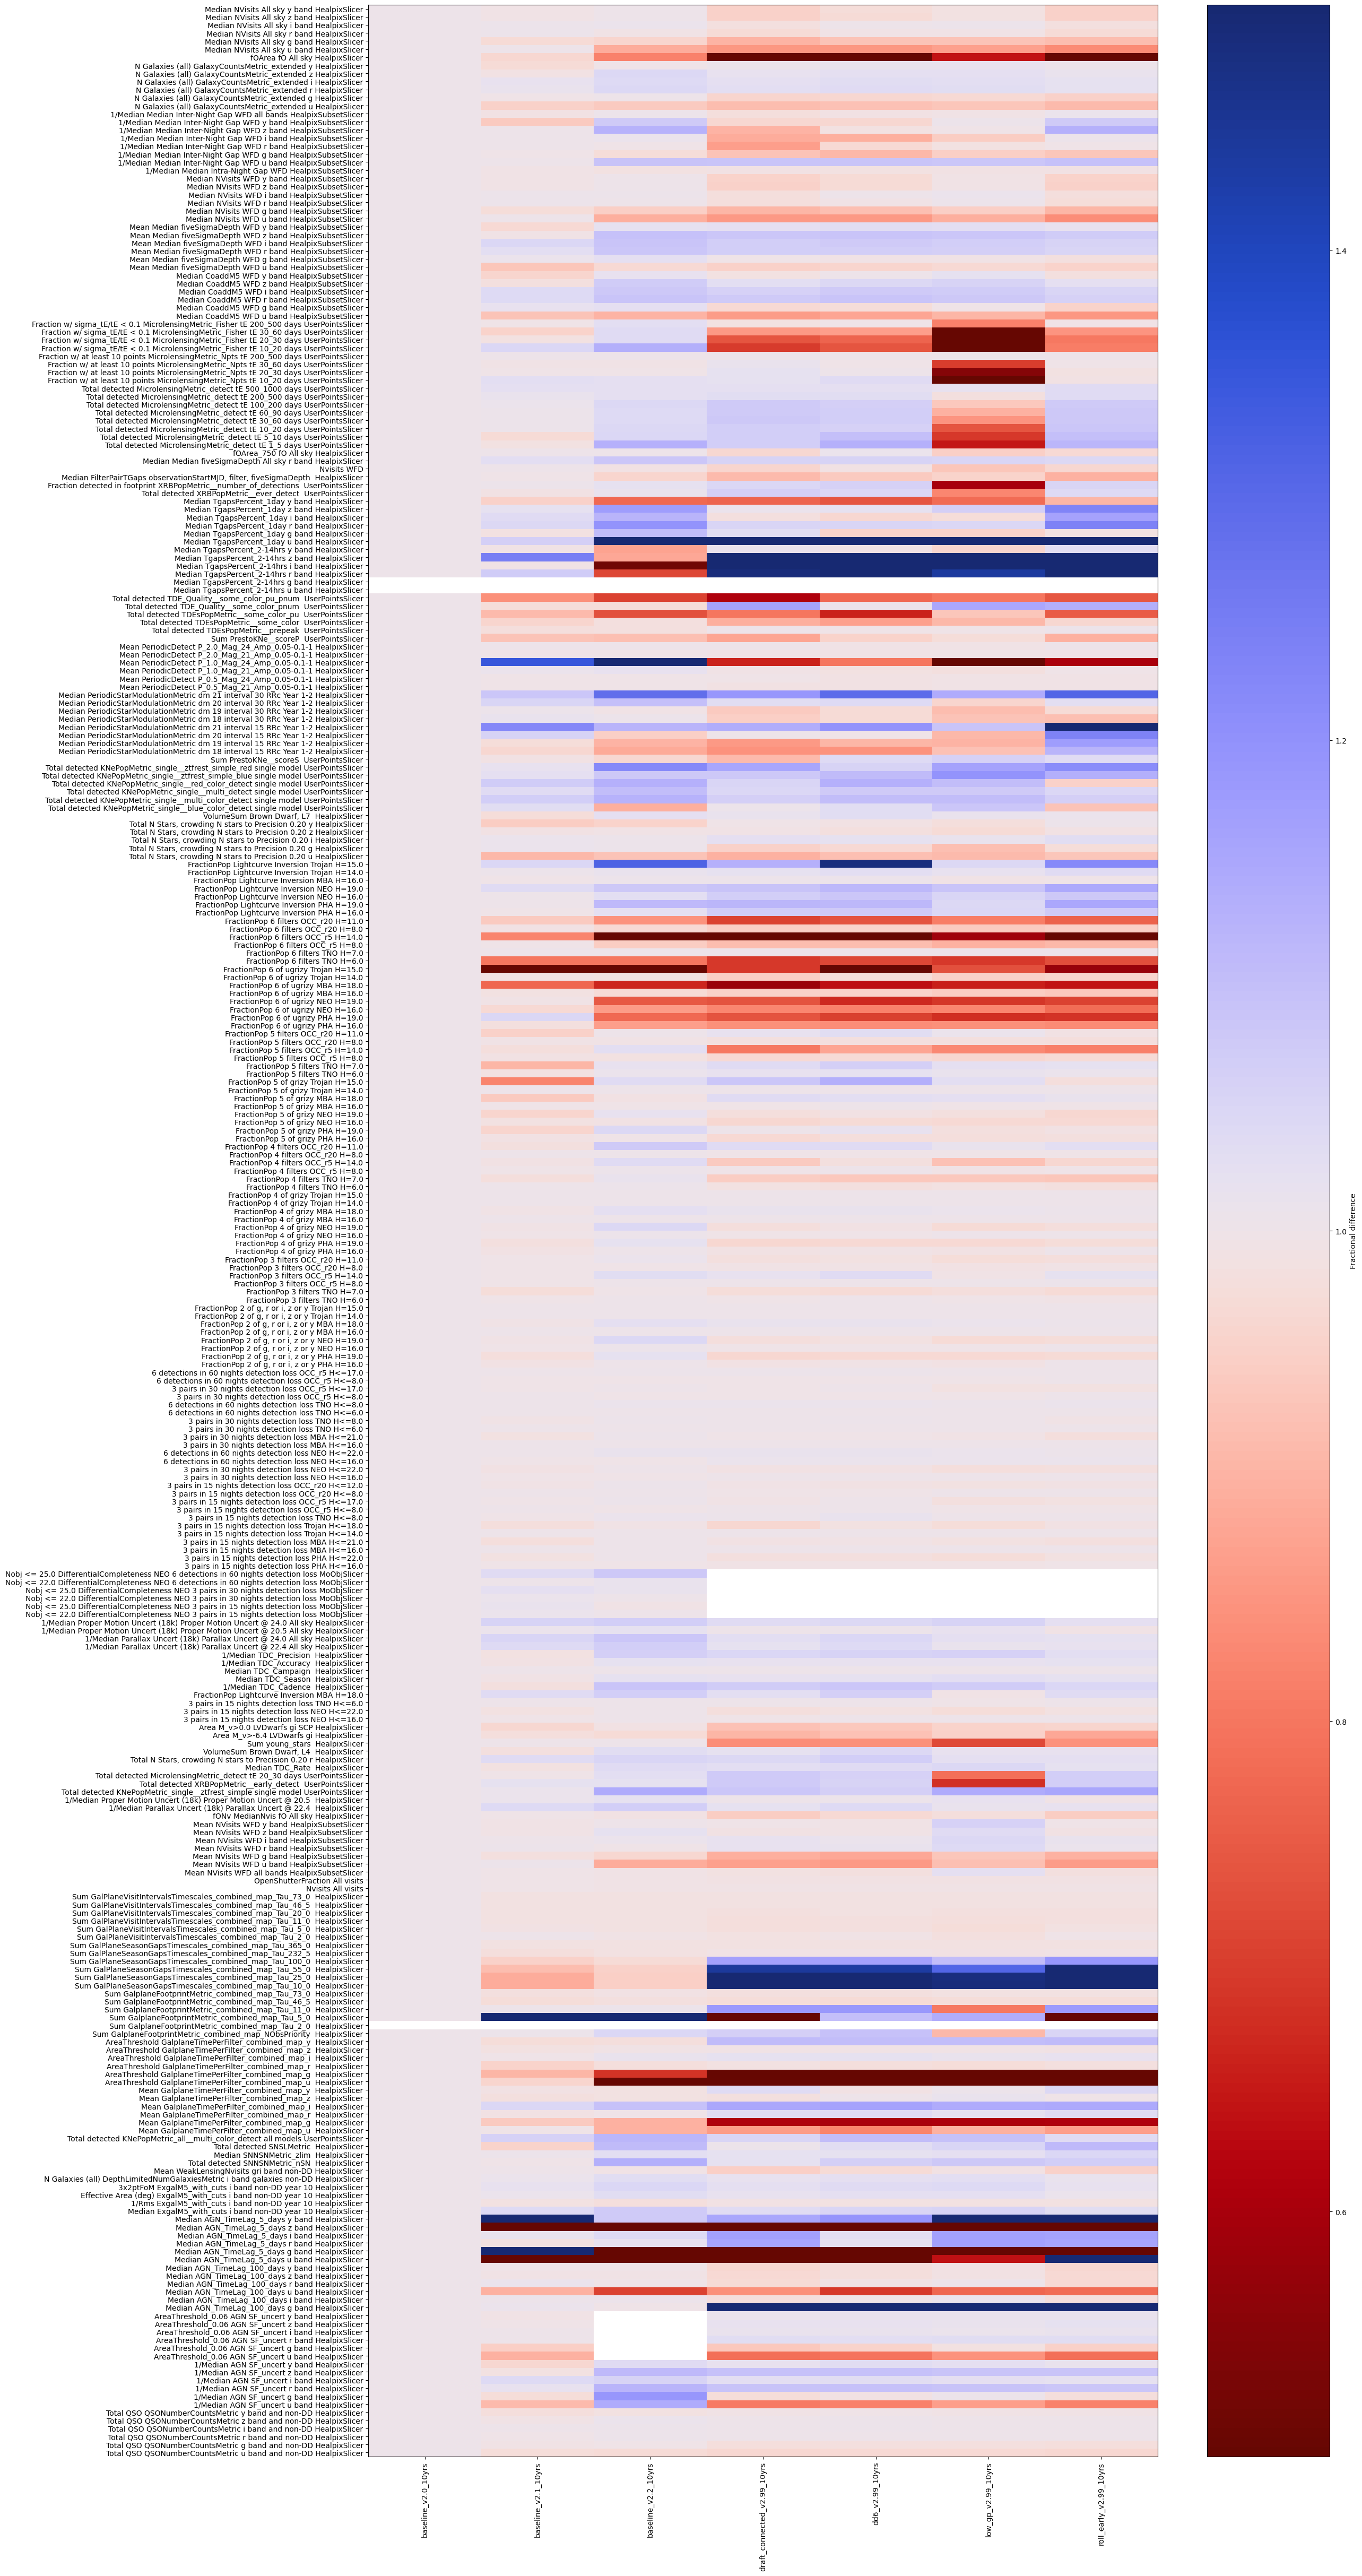

In [77]:
baseline_run = 'baseline_v2.0_10yrs'

these_runs = ['baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs'] + draft_runs

# We can plot them all together, but need to remove duplicates
non_dd = [m for m in msets if 'DD' not in m]
msub = metric_sets.loc[non_dd].reset_index(drop=True).drop('style', axis=1).drop('short_name', axis=1)
msub = msub.drop_duplicates().set_index('metric', drop=False, verify_integrity=True)

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                   baseline_run=baseline_run,
                                   #metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=1)
fig.set_figwidth(24)
fig.set_figheight(60)

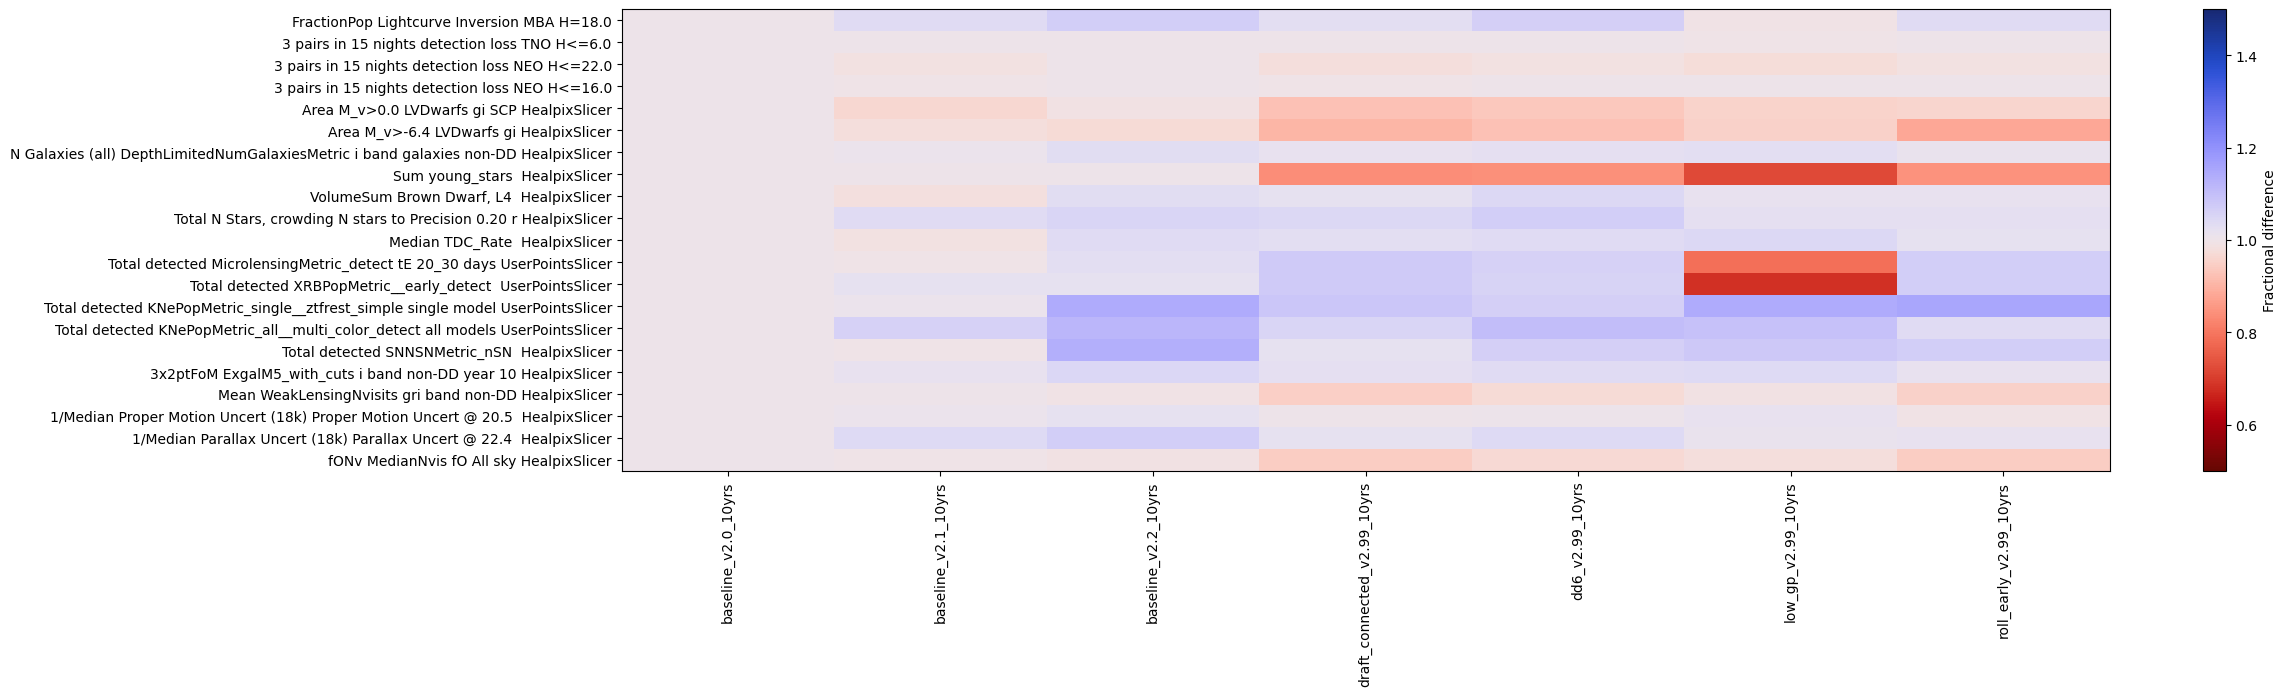

In [78]:
msub = metric_sets.loc['SCOC']
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                   baseline_run=baseline_run,
                                   #metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=1)
fig.set_figwidth(24)

In [79]:
# Time in DDFs
pd.DataFrame(summaries.loc[these_runs, 'Nvisits DDF']/summaries.loc[these_runs, 'Nvisits All visits'],
            columns=['Fraction DDF'])

Fraction DDF
run                                      
baseline_v2.0_10yrs              0.045169
baseline_v2.1_10yrs              0.045136
baseline_v2.2_10yrs              0.050087
draft_connected_v2.99_10yrs      0.072508
dd6_v2.99_10yrs                  0.051533
low_gp_v2.99_10yrs               0.072468
roll_early_v2.99_10yrs           0.072543

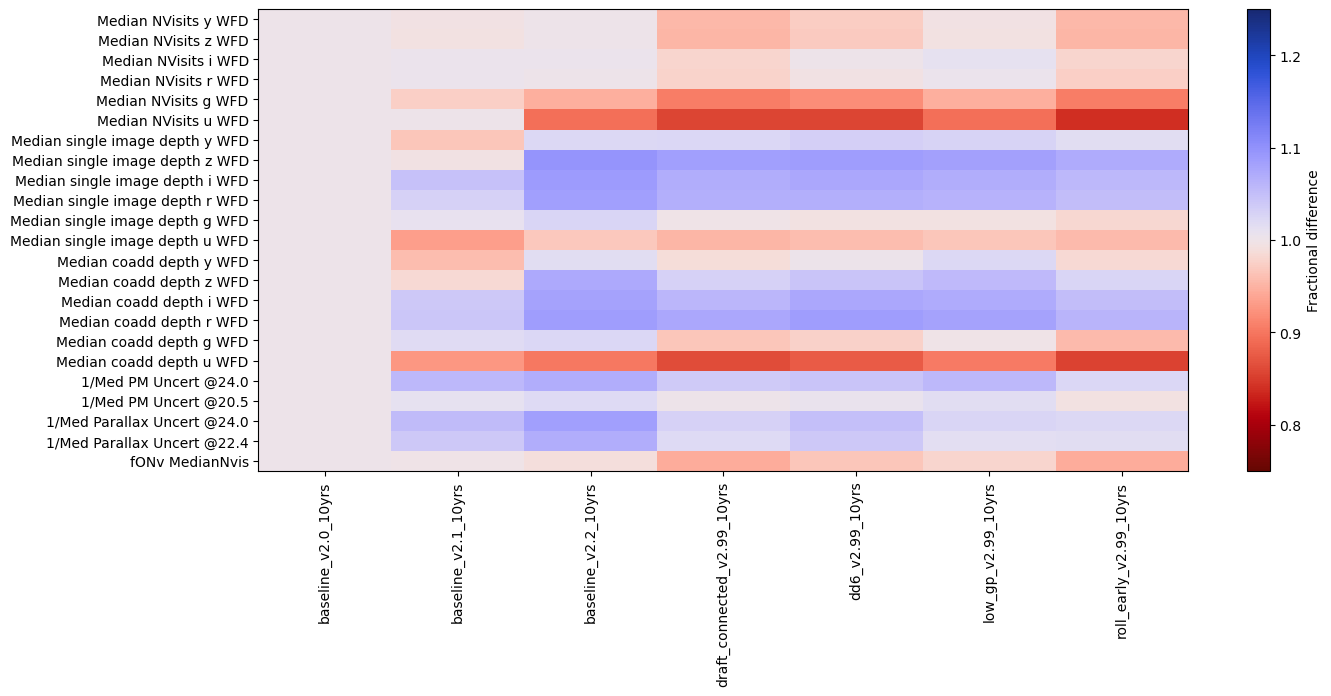

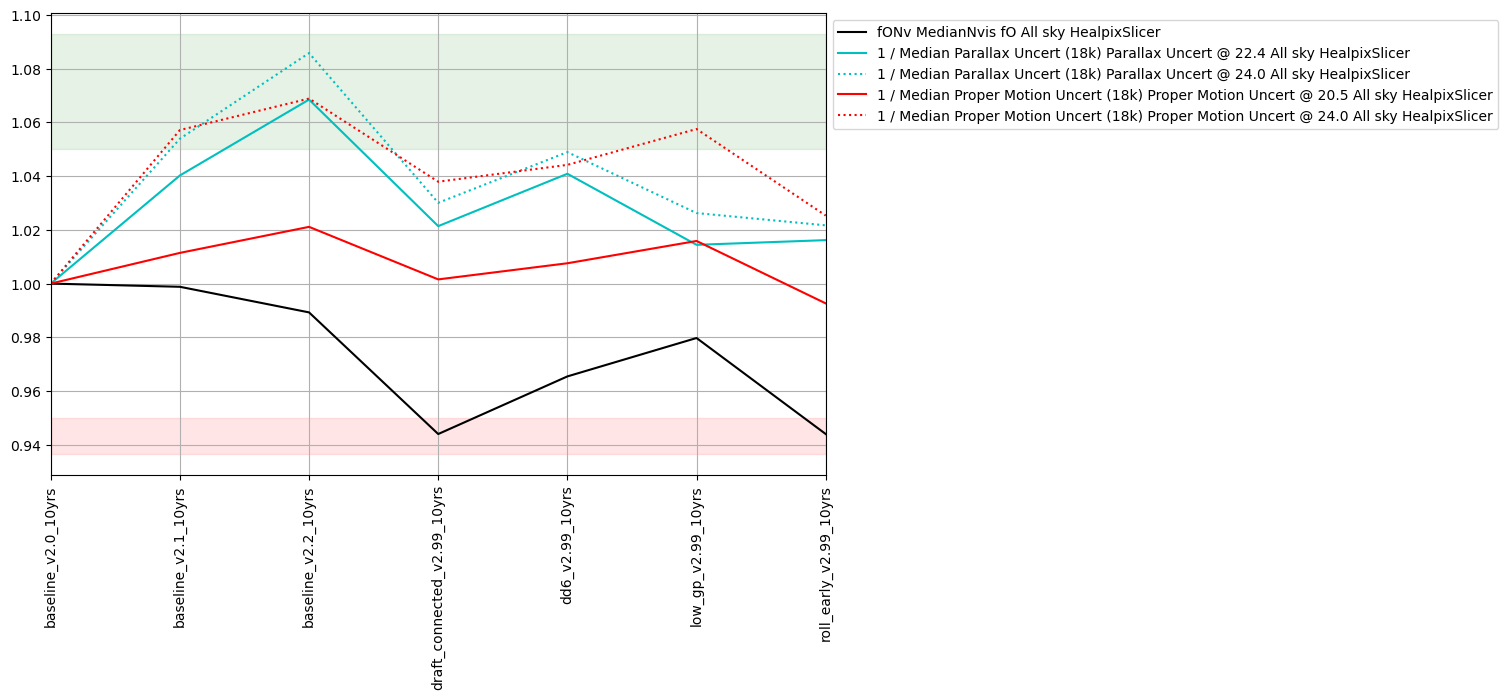

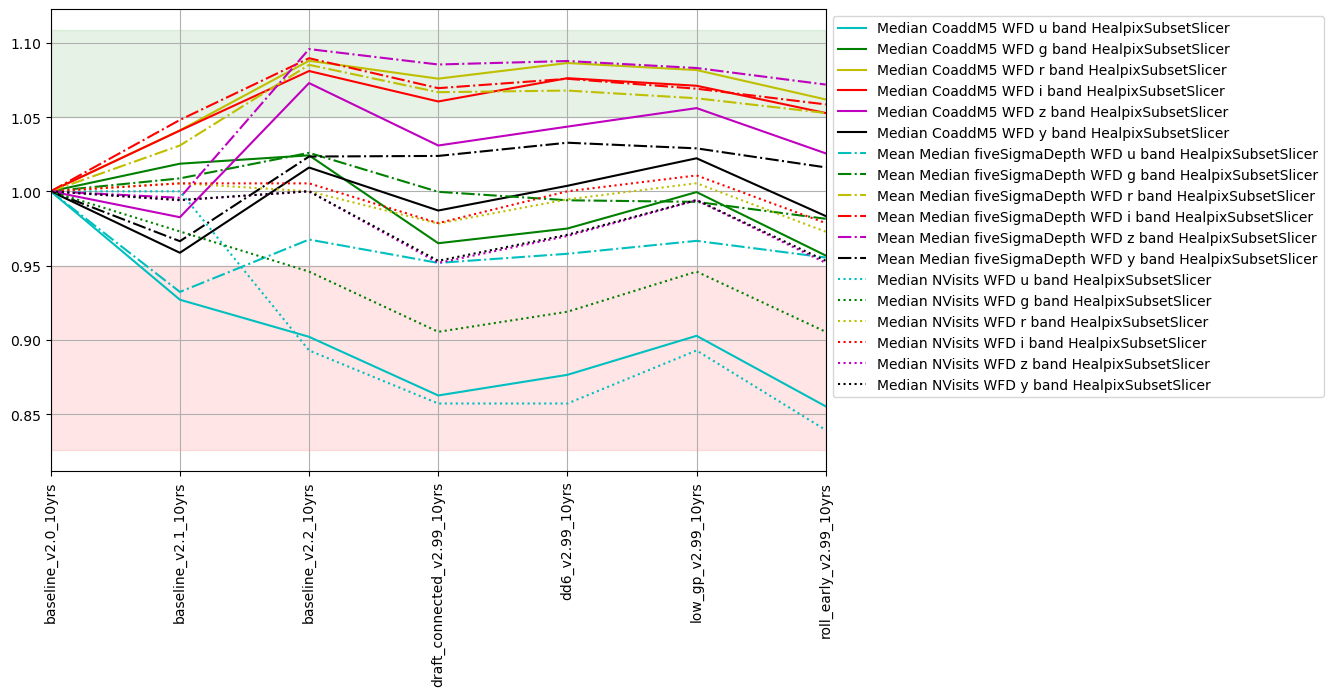

In [80]:
# Very basic metrics 

msub = metric_sets.loc[['SRD', 'WFD Depths']].reset_index('metric set')
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=0.5)
fig.set_figwidth(15)

msub = metric_sets.loc['SRD']
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']],
                             baseline_run=baseline_run,
                             metric_set=msub,
                            horizontal_quantity='run', 
                             vertical_quantity='value')

msub = metric_sets.loc['WFD Depths']
fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']],
                             baseline_run=baseline_run,
                             metric_set=msub,
                            horizontal_quantity='run', 
                             vertical_quantity='value')

In [93]:
msubm = list(metric_sets.loc['WFD Depths'].query('metric.str.contains("NVisits")', 
                                                 engine='python')['metric'].values)
msubm.append('Median NVisits WFD all bands HealpixSubsetSlicer')
summaries.loc[these_runs, msubm]

metric                       Median NVisits WFD u band HealpixSubsetSlicer  \
run                                                                          
baseline_v2.0_10yrs                                                   56.0   
baseline_v2.1_10yrs                                                   56.0   
baseline_v2.2_10yrs                                                   50.0   
draft_connected_v2.99_10yrs                                           48.0   
dd6_v2.99_10yrs                                                       48.0   
low_gp_v2.99_10yrs                                                    50.0   
roll_early_v2.99_10yrs                                                47.0   

metric                       Median NVisits WFD g band HealpixSubsetSlicer  \
run                                                                          
baseline_v2.0_10yrs                                                   74.0   
baseline_v2.1_10yrs                                                   72.0   
baseline_v2.2_10yrs                                                   70.0   
draft_connected_v2.99_10yrs                                           67.0   
dd6_v2.99_10yrs                                                       68.0   
low_gp_v2.99_10yrs                                                    70.0   
roll_early_v2.99_10yrs                                                67.0   

metric                       Median NVisits WFD r band HealpixSubsetSlicer  \
run                                                                          
baseline_v2.0_10yrs                                                  184.0   
baseline_v2.1_10yrs                                                  185.0   
baseline_v2.2_10yrs                                                  184.0   
draft_connected_v2.99_10yrs                                          180.0   
dd6_v2.99_10yrs                                                      183.0   
low_gp_v2.99_10yrs                                                   185.0   
roll_early_v2.99_10yrs                                               179.0   

metric                       Median NVisits WFD i band HealpixSubsetSlicer  \
run                                                                          
baseline_v2.0_10yrs                                                  187.0   
baseline_v2.1_10yrs                                                  188.0   
baseline_v2.2_10yrs                                                  188.0   
draft_connected_v2.99_10yrs                                          183.0   
dd6_v2.99_10yrs                                                      187.0   
low_gp_v2.99_10yrs                                                   189.0   
roll_early_v2.99_10yrs                                               183.0   

metric                       Median NVisits WFD z band HealpixSubsetSlicer  \
run                                                                          
baseline_v2.0_10yrs                                                  166.0   
baseline_v2.1_10yrs                                                  165.0   
baseline_v2.2_10yrs                                                  166.0   
draft_connected_v2.99_10yrs                                          158.0   
dd6_v2.99_10yrs                                                      161.0   
low_gp_v2.99_10yrs                                                   165.0   
roll_early_v2.99_10yrs                                               158.0   

metric                       Median NVisits WFD y band HealpixSubsetSlicer  \
run                                                                          
baseline_v2.0_10yrs                                                  171.0   
baseline_v2.1_10yrs                                                  170.0   
baseline_v2.2_10yrs                                                  171.0   
draft_connected_v2.99_10yrs                                          163.0   
dd6_v2.99_10yrs  

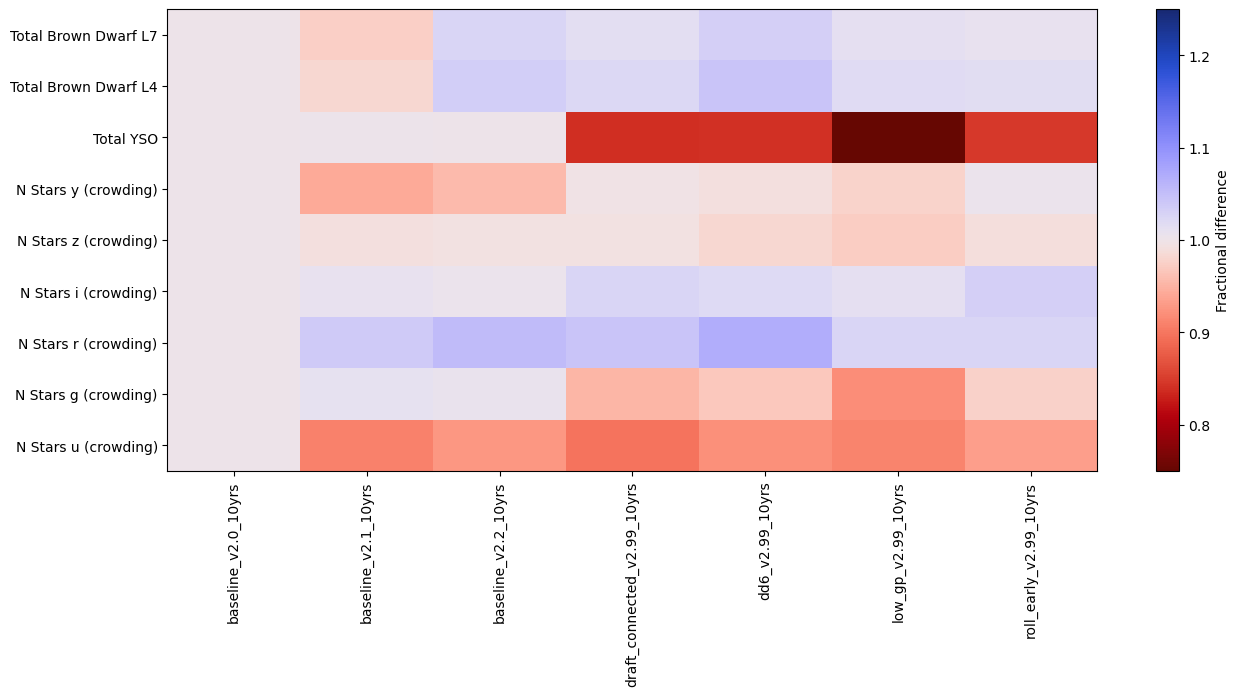

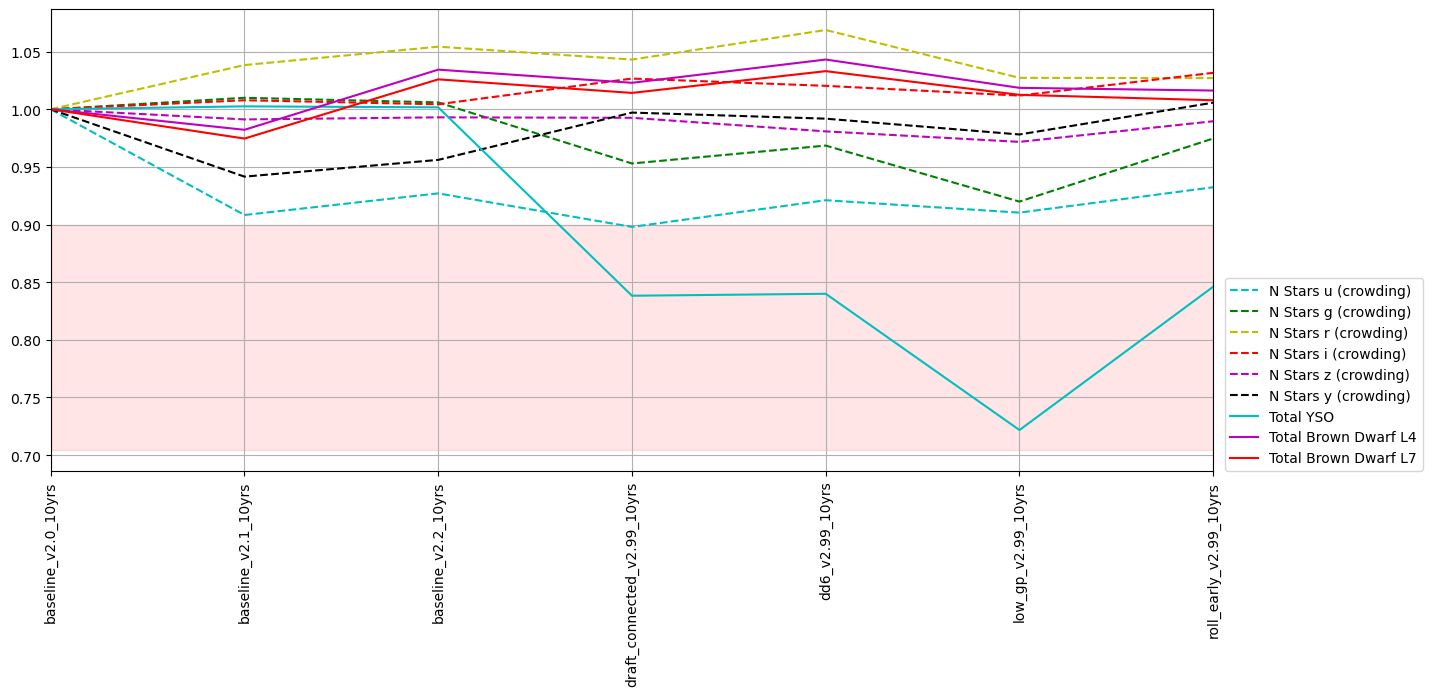

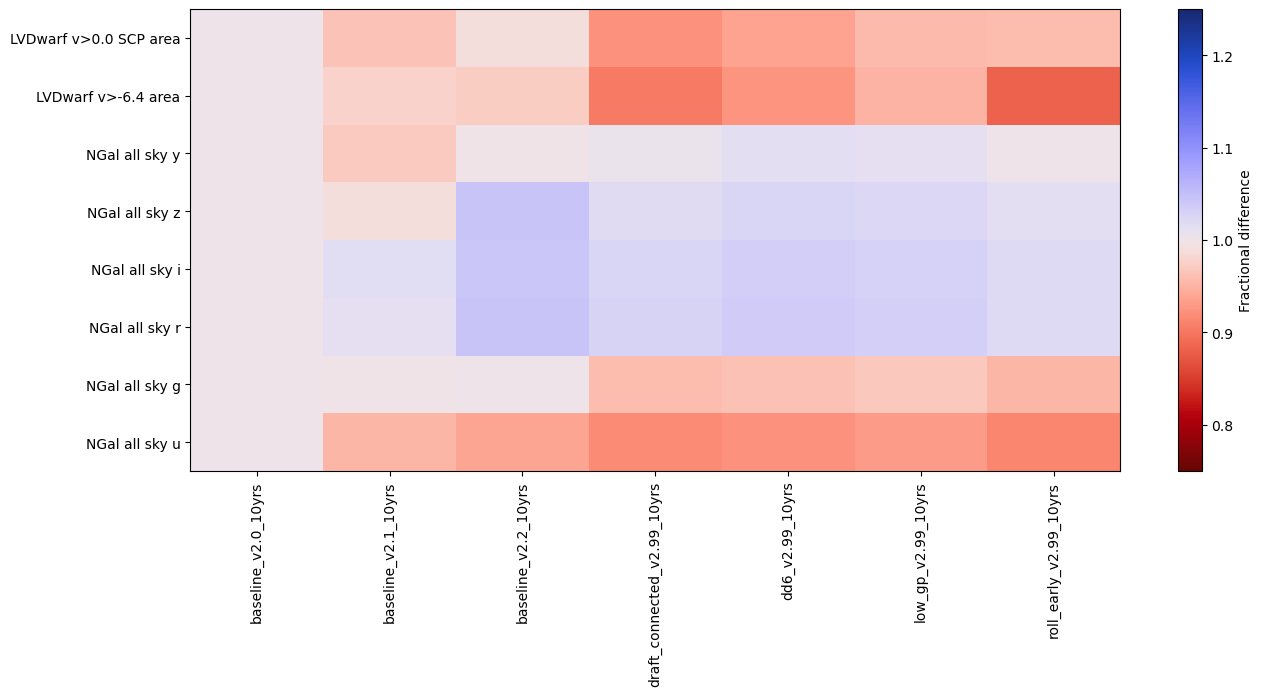

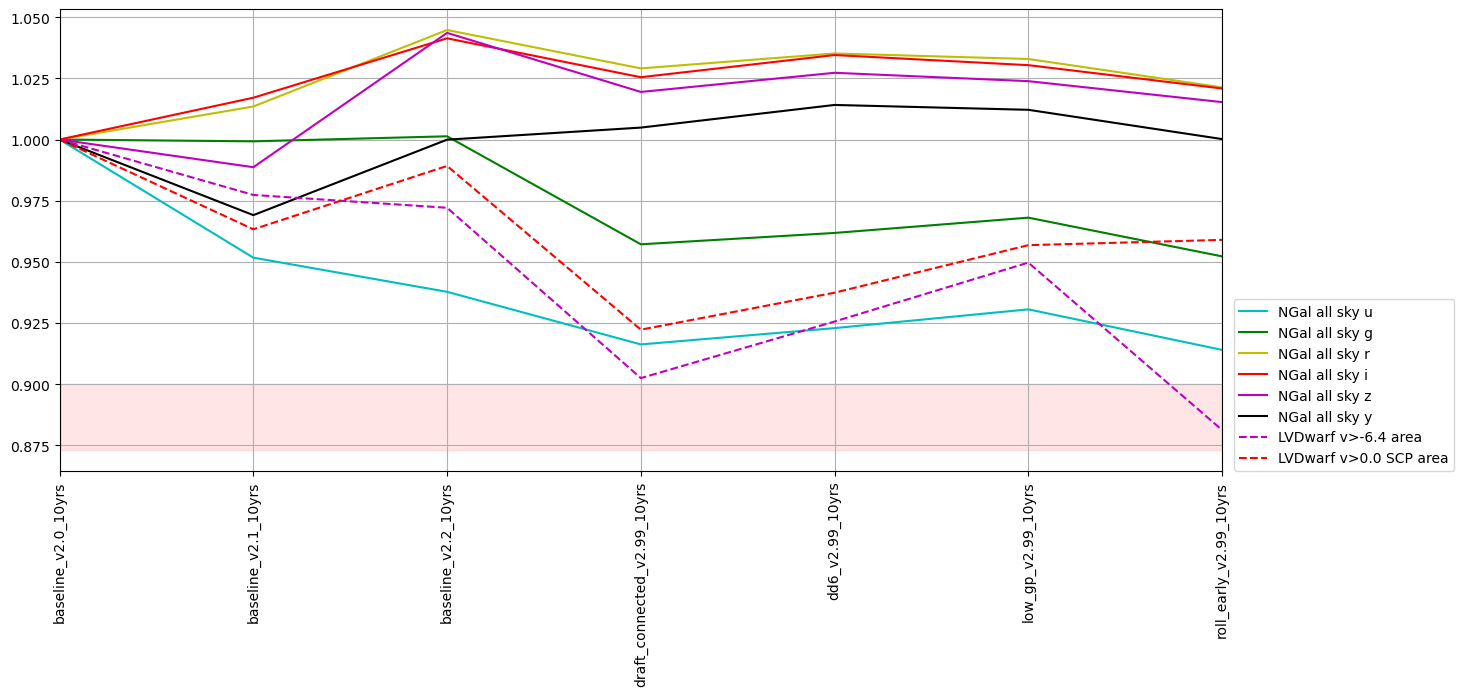

In [81]:
# Stars and Galaxy counts metrics
k_sets = ['Stars', 'galaxies']
for k in k_sets:
    msub = metric_sets.loc[k]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=msub['short_name'],
                                       metric_set=msub,
                                      color_range=0.5)
    fig.set_figwidth(15)


    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_sets.loc[k],
                                  metric_label_map=metric_sets.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value', 
                                 shade_fraction=0.1)
    fig.set_figwidth(15)
    ylim = list(ax.get_ylim())
    ax.set_ylim(max(0.2, ylim[0]), min(2, ylim[1]))
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')

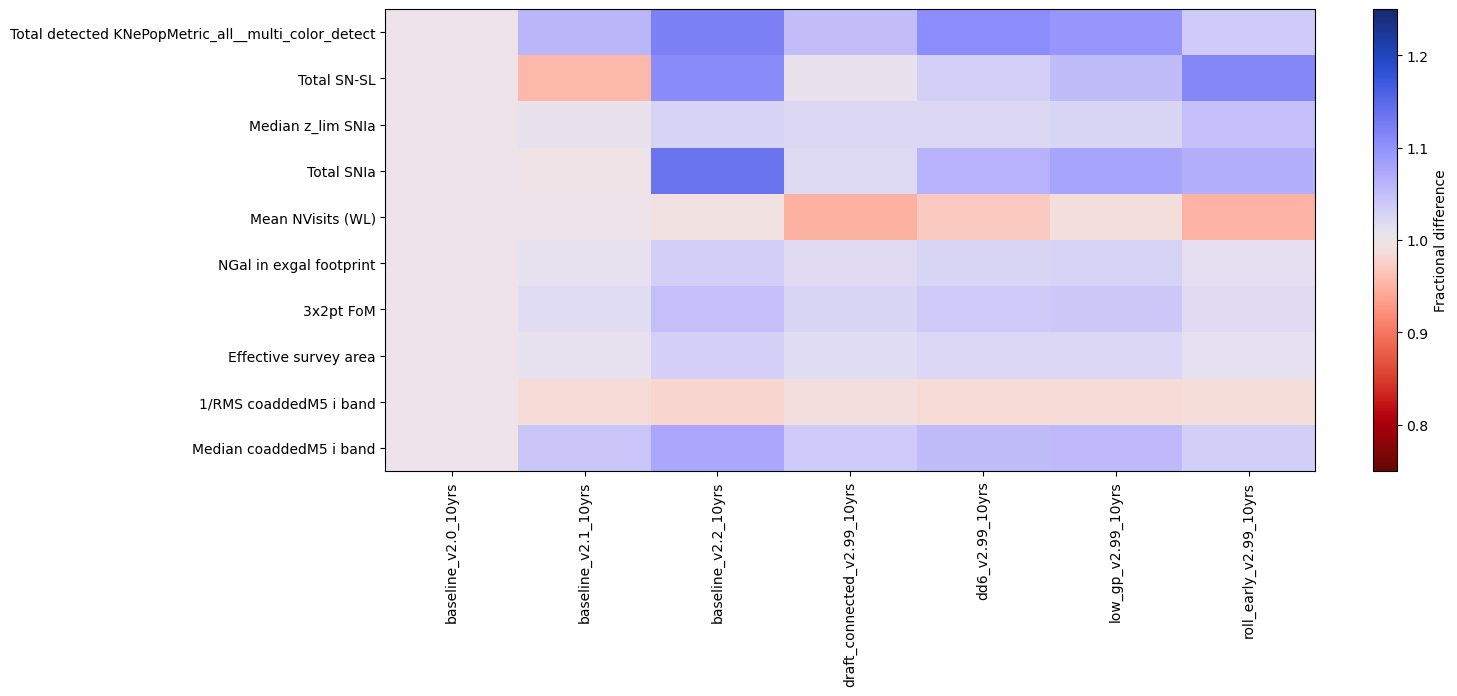

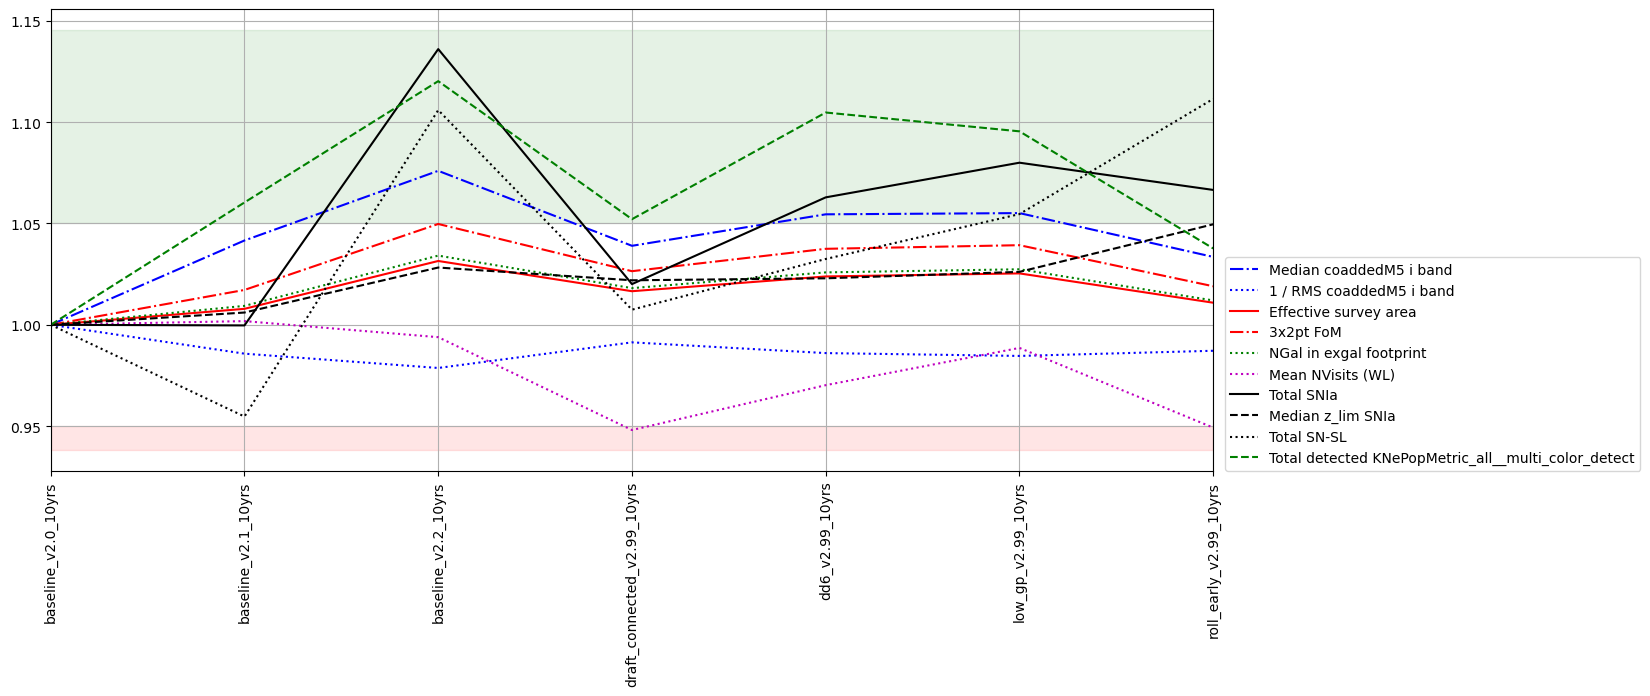

In [82]:
# DESC metrics
k_sets = [k for k in msets if k.startswith('DESC') and not k.endswith('DDF')]

for k in k_sets:
    msub = metric_sets.loc[k]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=msub['short_name'],
                                       metric_set=msub,
                                      color_range=0.5)
    fig.set_figwidth(15)


    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_sets.loc[k],
                                  metric_label_map=metric_sets.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    #ax.set_ylim(0.5, 1.5)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')


SSO discovery
SSO lightcurve inversion


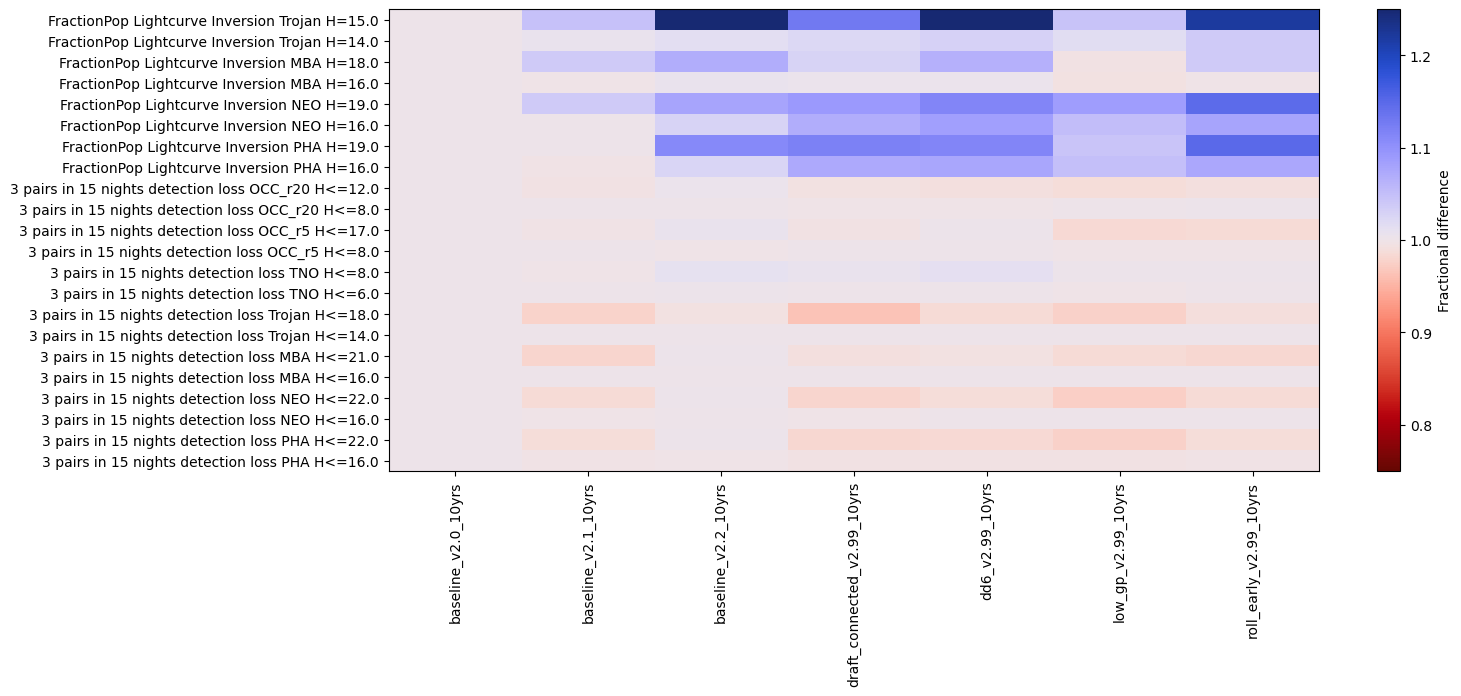

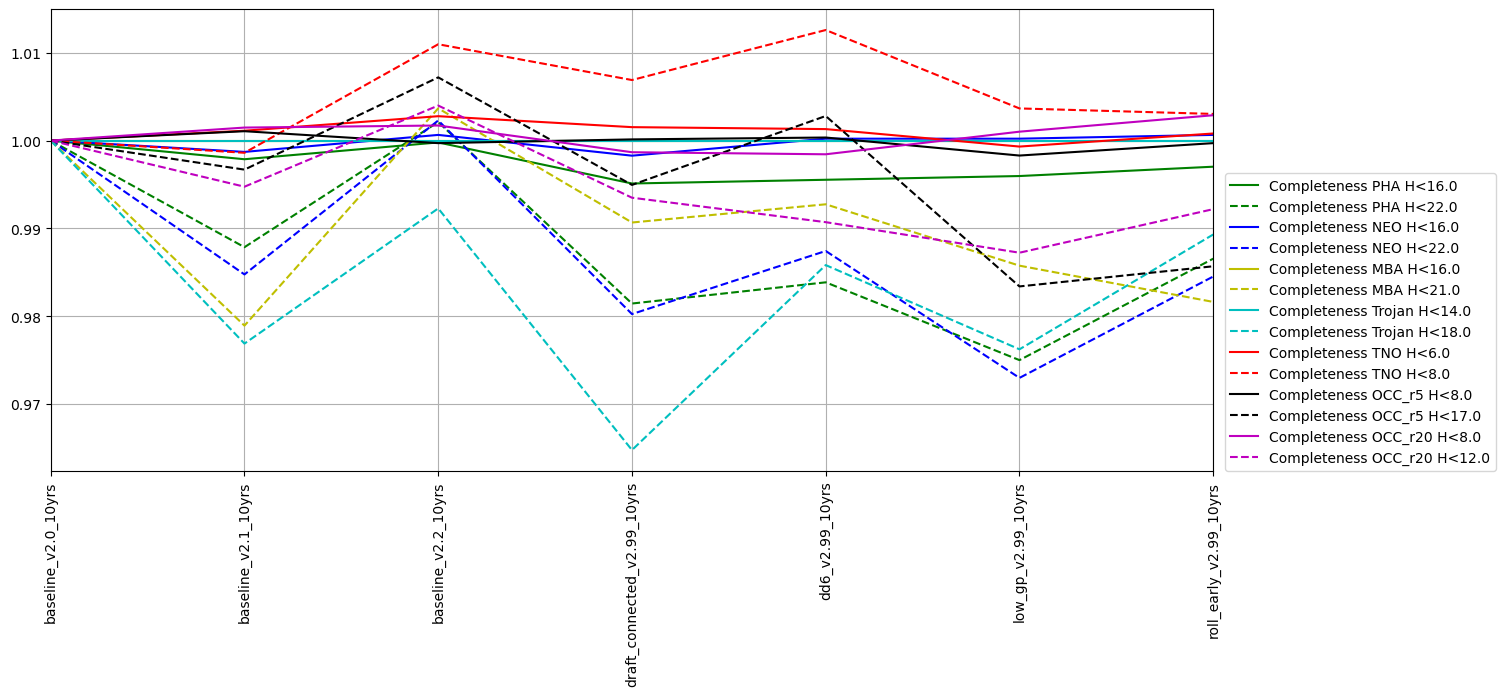

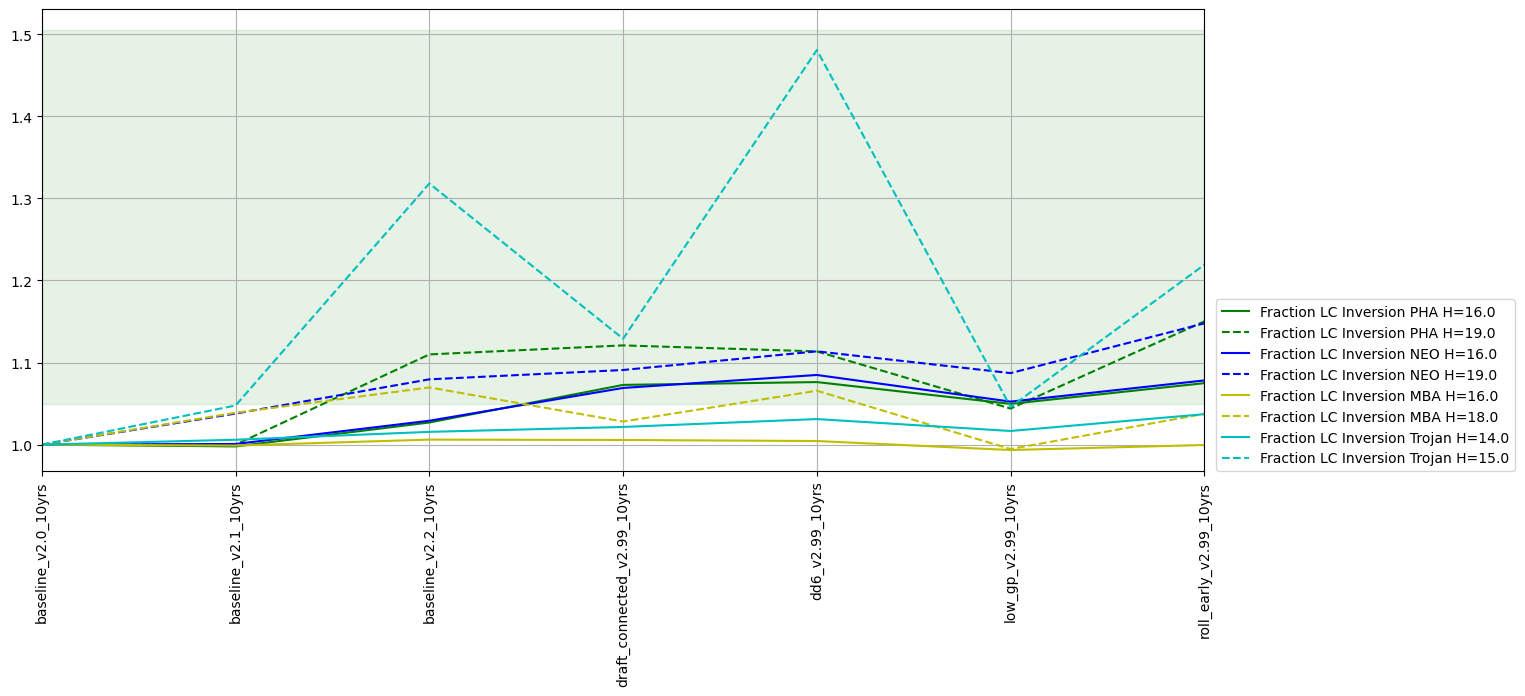

In [83]:
# sso metrics
k_sets = ['SSO discovery', 'SSO lightcurve inversion']

msub = metric_sets.loc[k_sets].reset_index('metric set')
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, msub['metric']], 
                                   baseline_run=baseline_run,
                                   #metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=0.5)
fig.set_figwidth(15)


for k in k_sets:
    print(k)
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_sets.loc[k],
                                  metric_label_map=metric_sets.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    #ax.set_ylim(0.5, 1.5)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')


/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/runComparison/summary_plots.py:326: UserWarning: There are infinite values in the plot of Median TgapsPercent_2-14hrs u band.
  warnings.warn(f"There are infinite values in the plot of {idx}.")


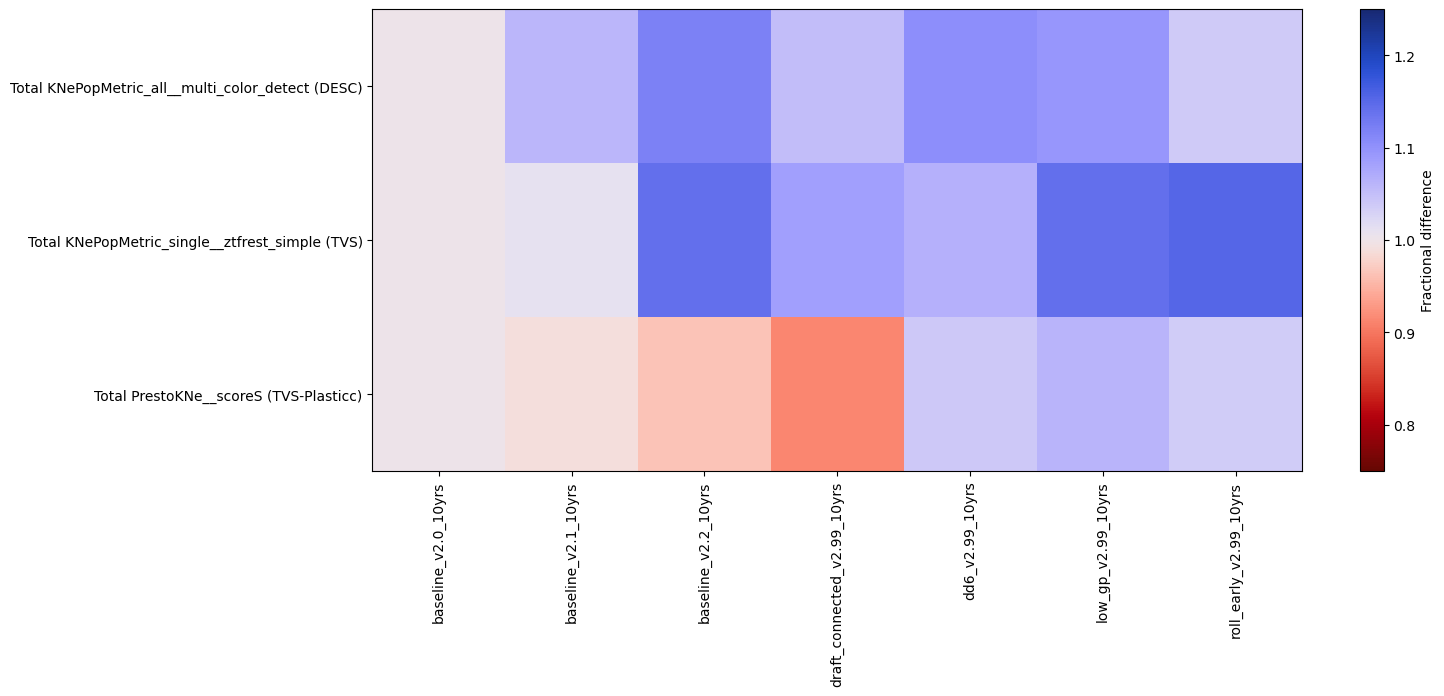

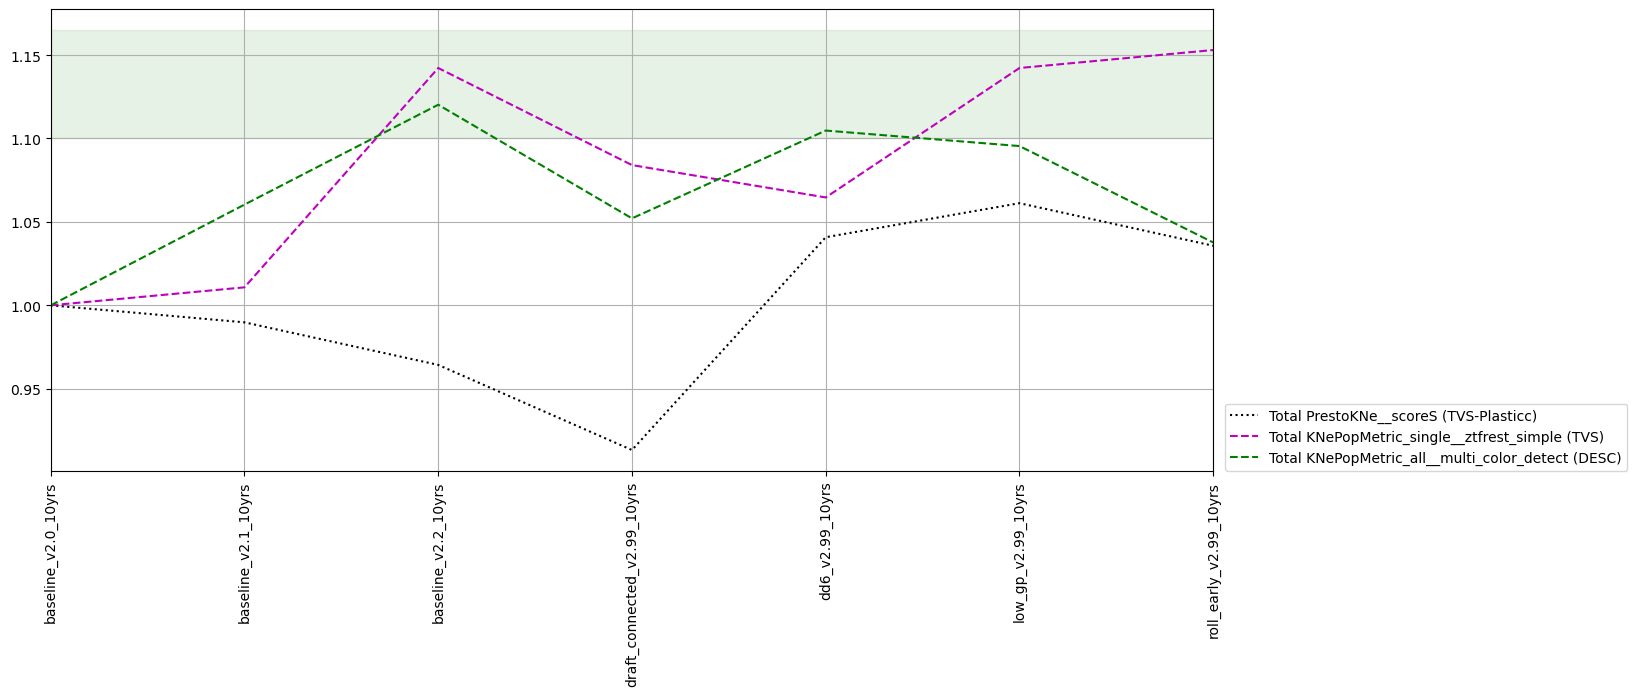

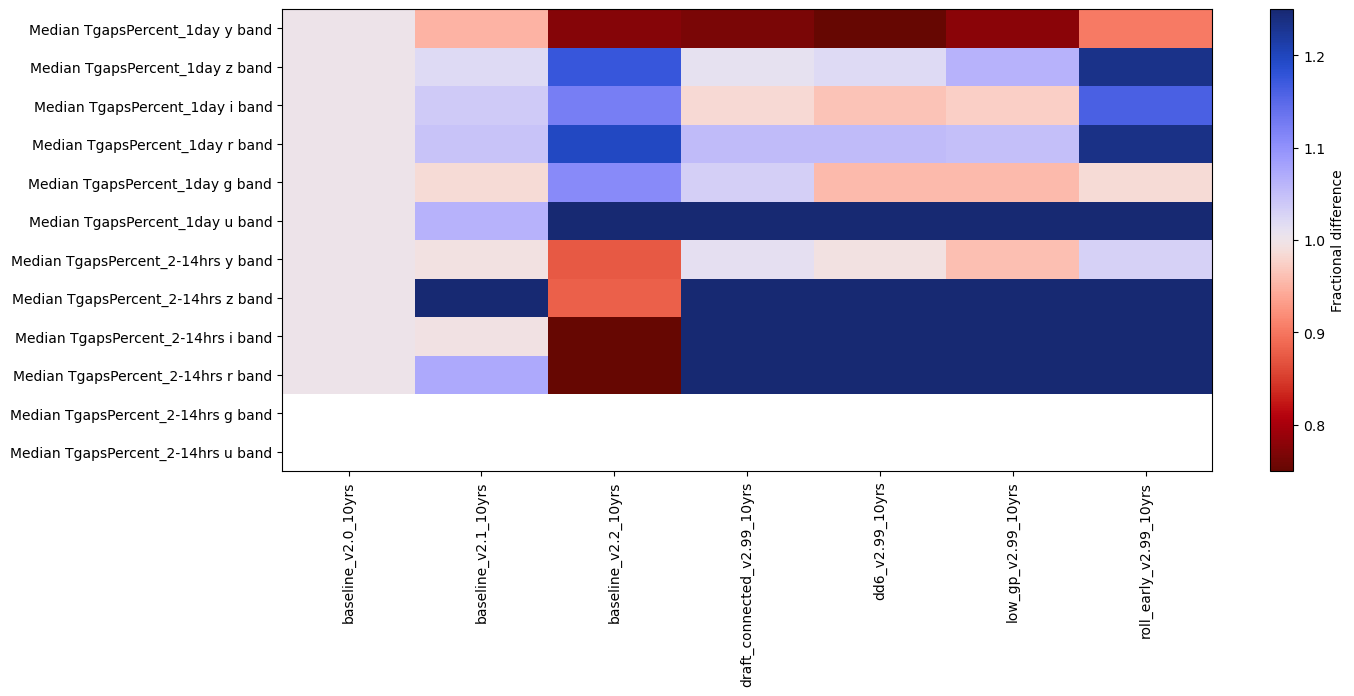

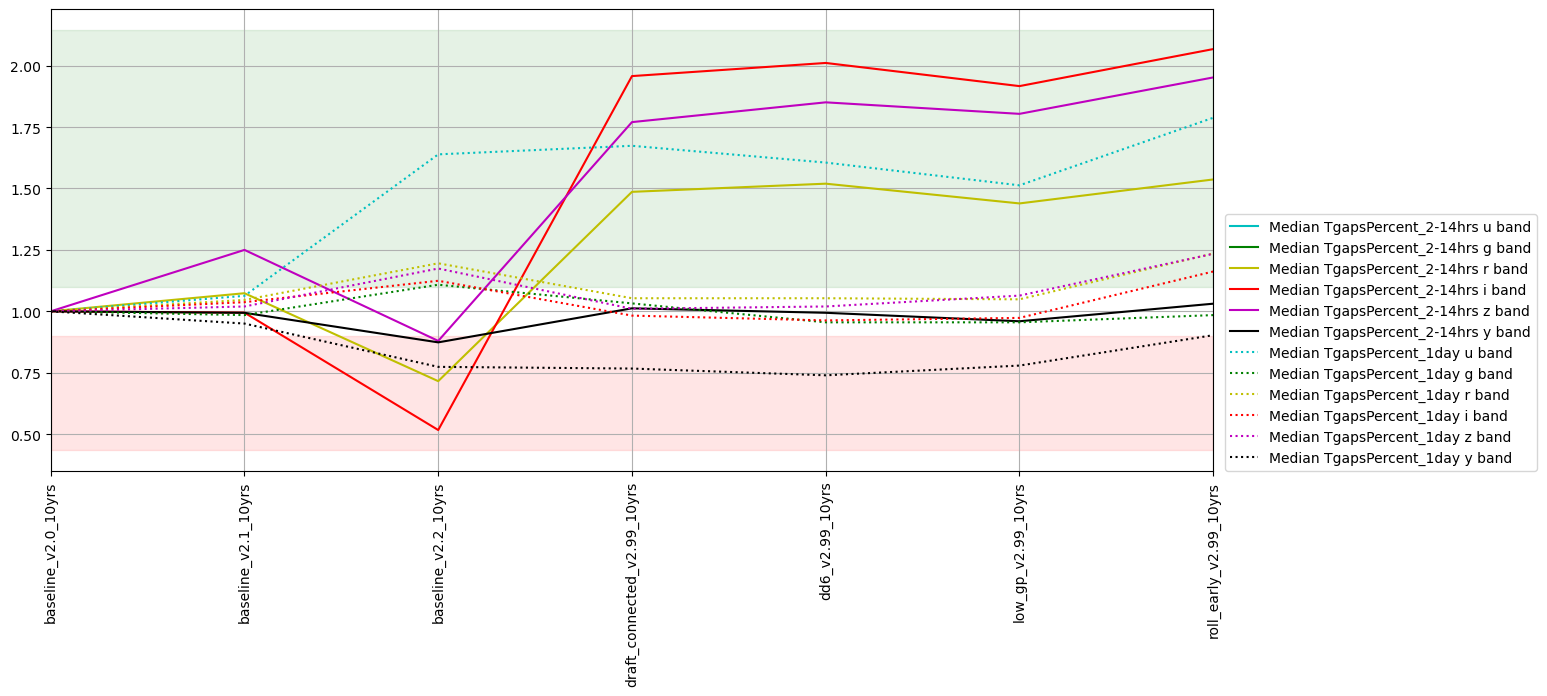

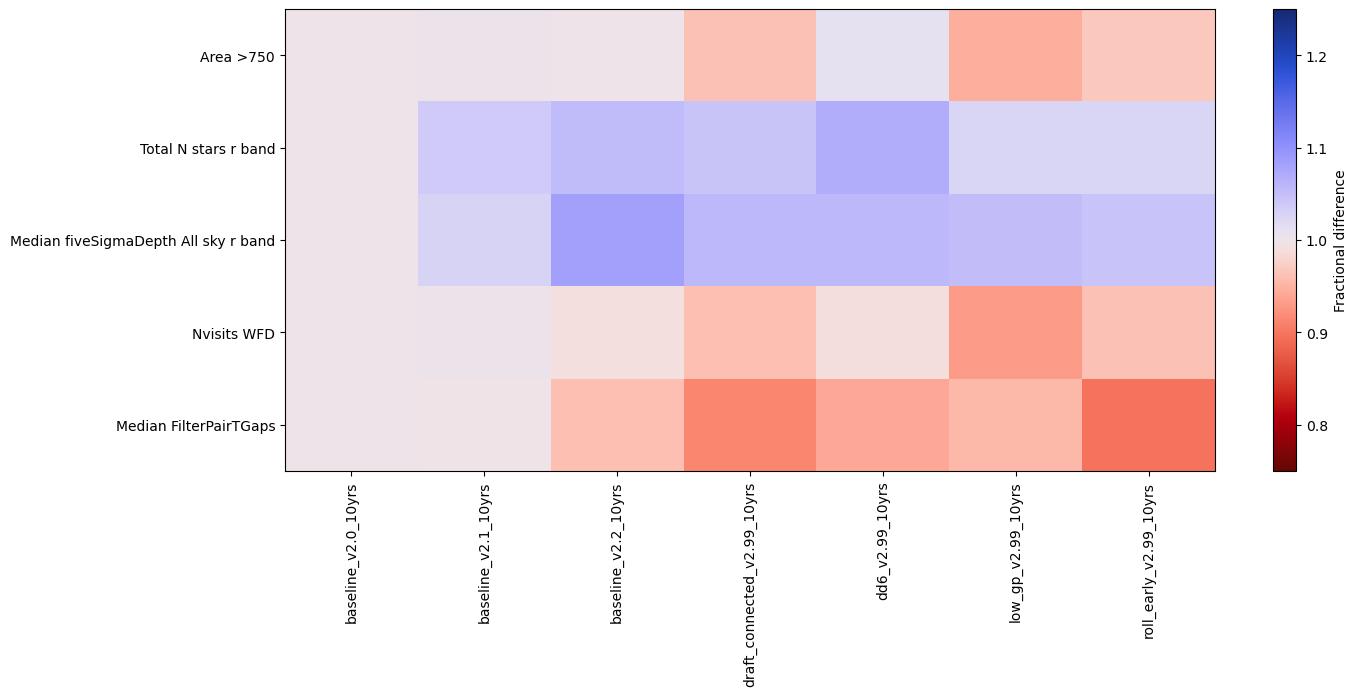

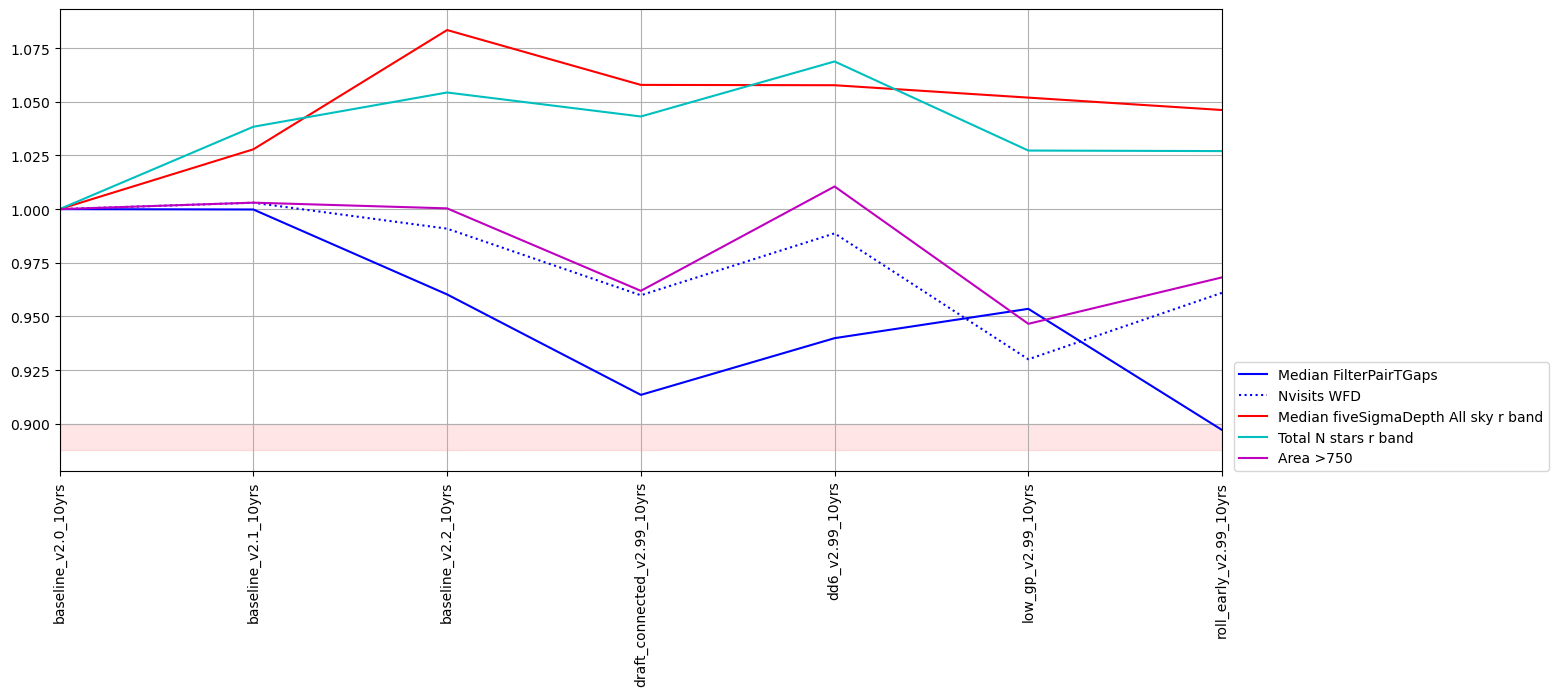

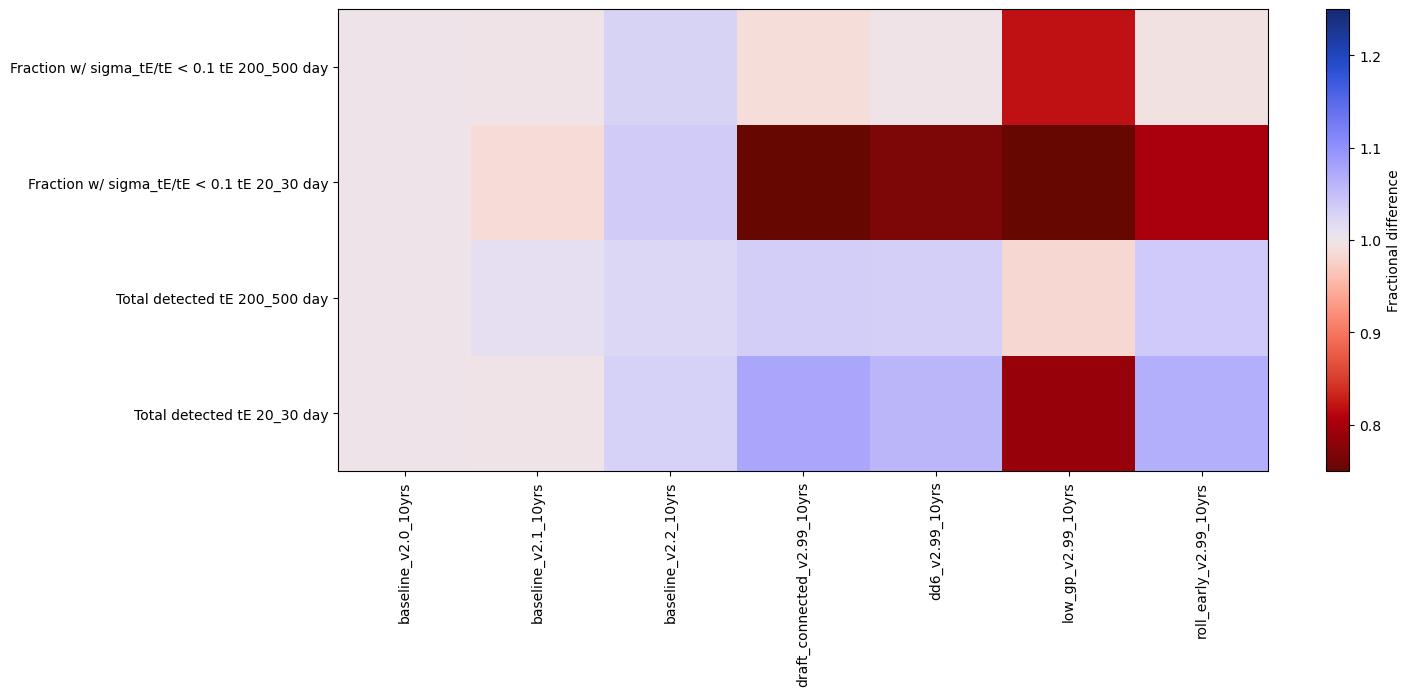

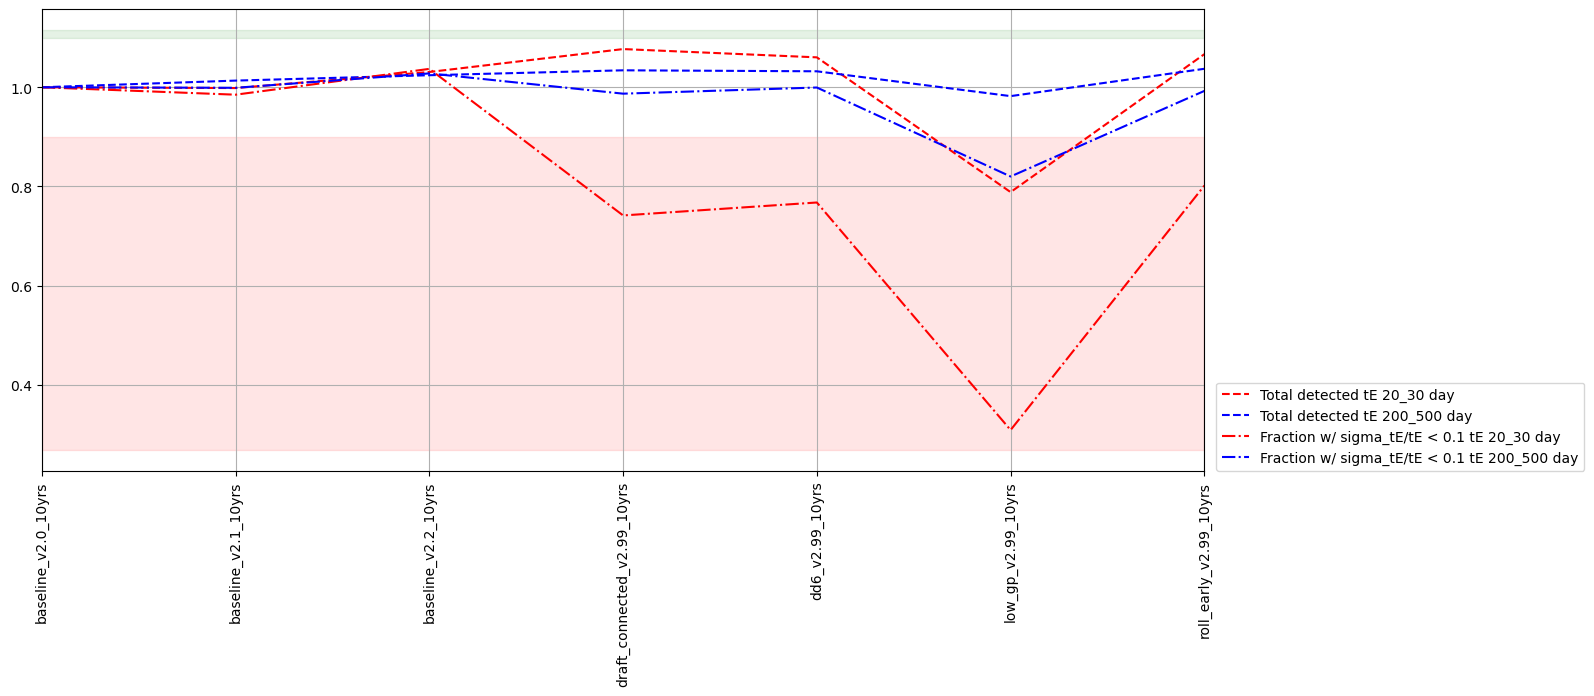

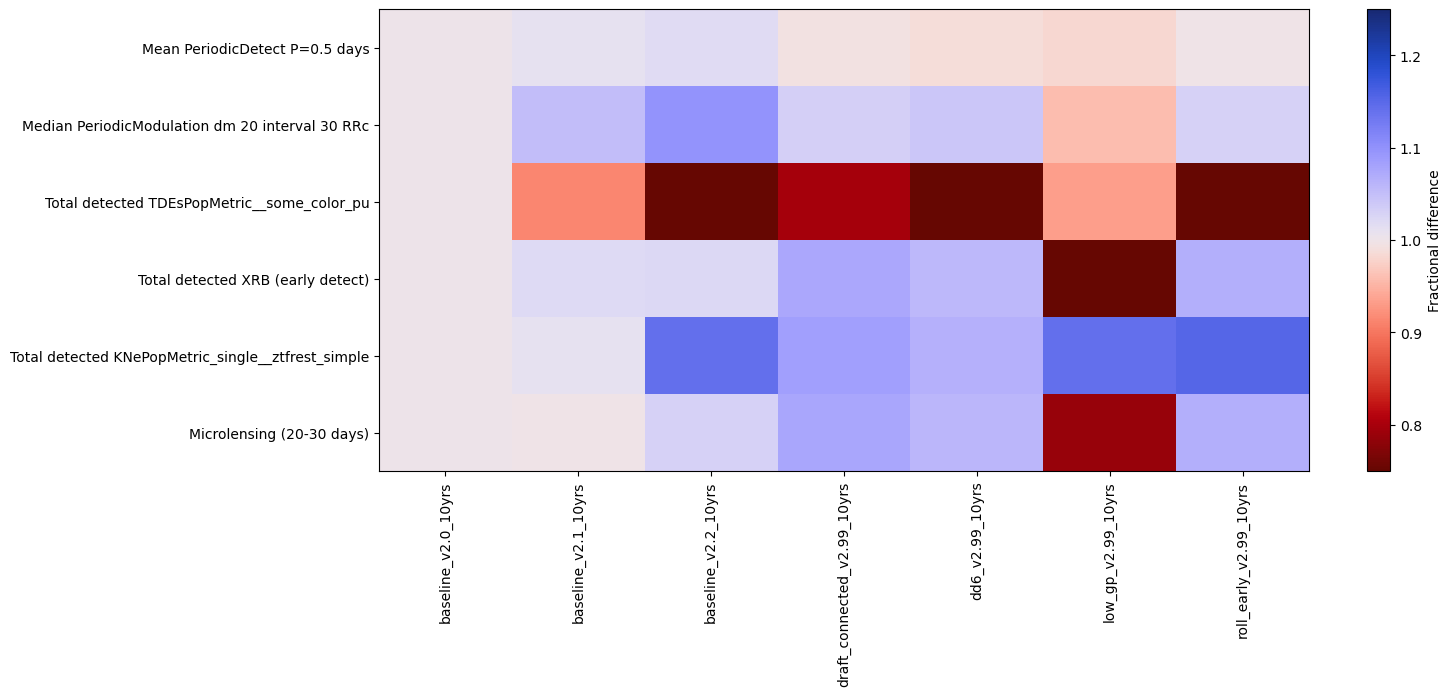

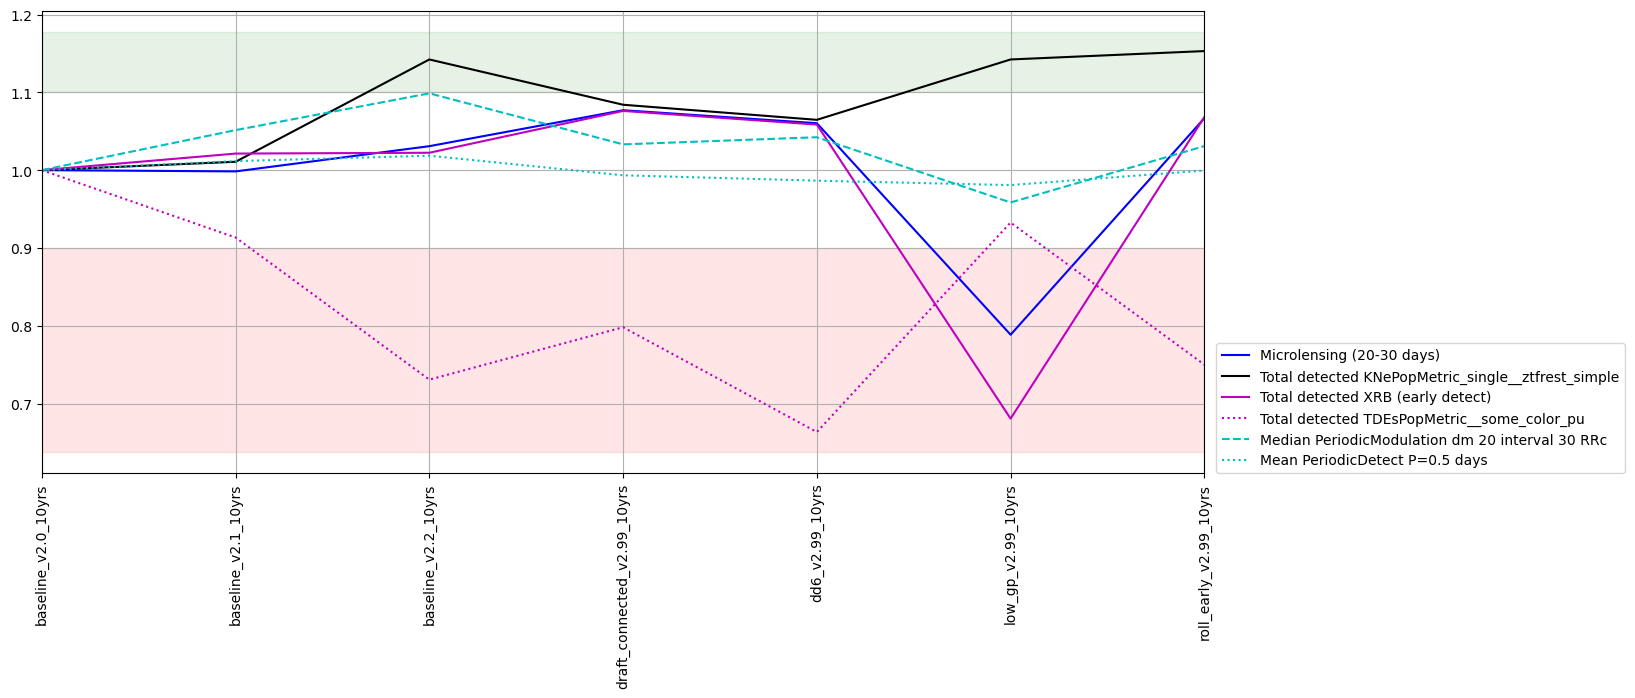

In [85]:
# TVS metrics
k_sets = [k for k in msets if k.startswith('TVS') and (k.endswith('short') or ('Tgaps' in k) or ('anomalies' in k)) ]

for k in k_sets:
    msub = metric_sets.loc[k]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=msub['short_name'],
                                       metric_set=msub,
                                      color_range=0.5)
    fig.set_figwidth(15)


    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_sets.loc[k],
                                  metric_label_map=metric_sets.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value', 
                                 shade_fraction=0.1)
    fig.set_figwidth(15)
    ylim = list(ax.get_ylim())
    ax.set_ylim(max(0.2, ylim[0]), min(3, ylim[1]))
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')


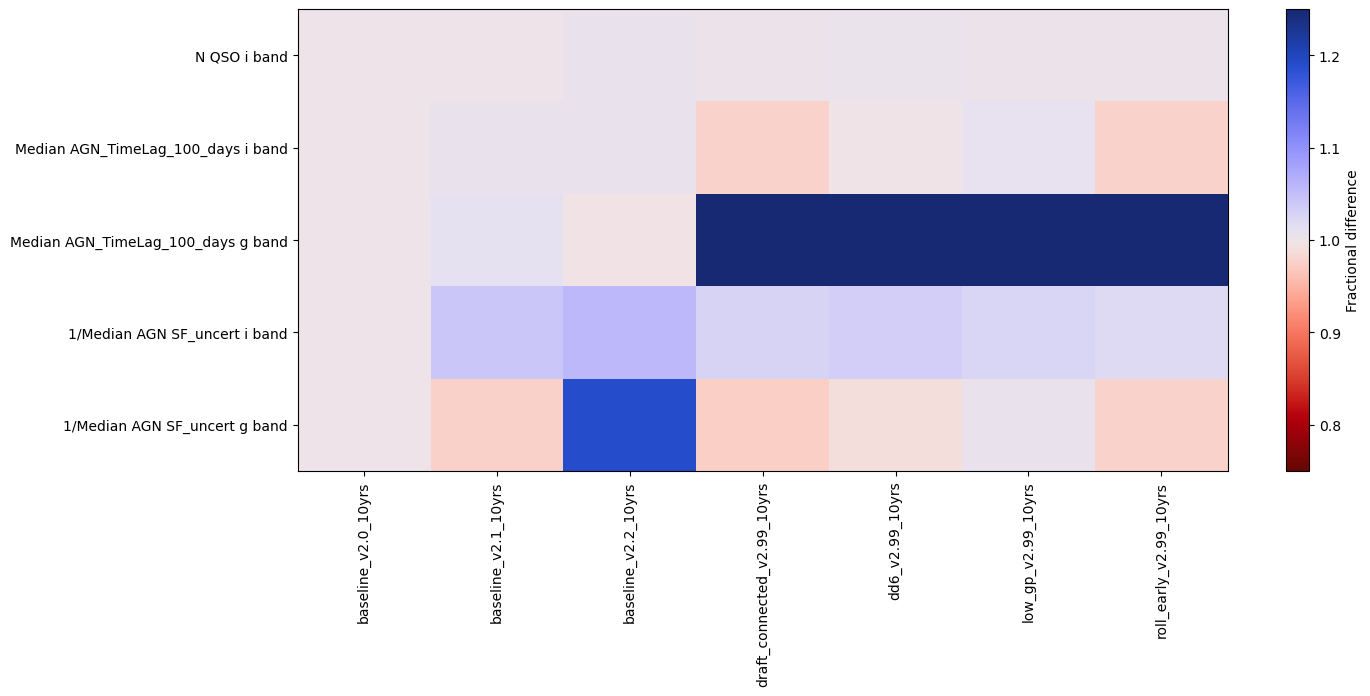

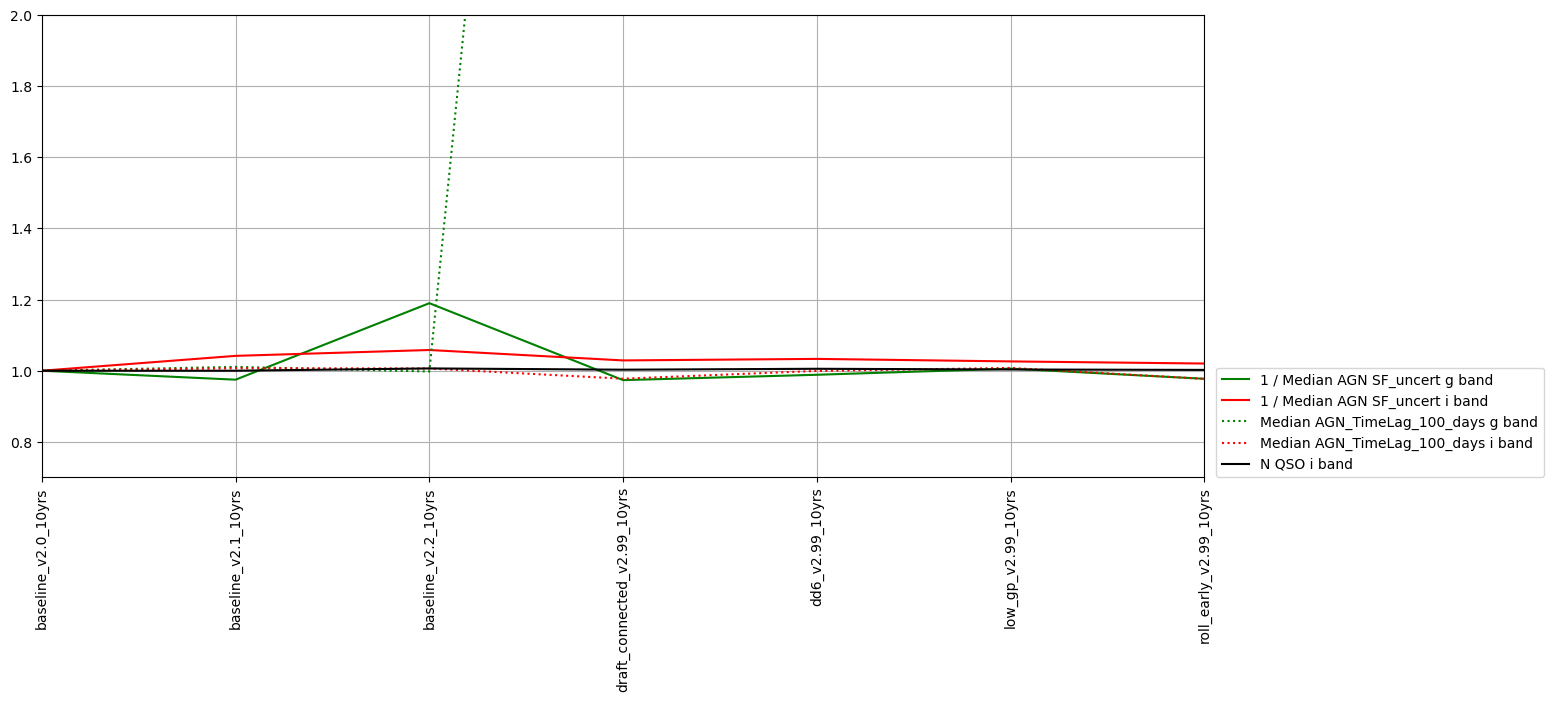

In [94]:
k = 'AGN short'
# AGN metrics
k_sets = ['AGN short']

msub = metric_sets.loc[k_sets].reset_index('metric set')
fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=0.5)
fig.set_figwidth(15)


for k in k_sets:
    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_sets.loc[k],
                                  metric_label_map=metric_sets.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value',
                                 shade_fraction=0)
    ylims = ax.get_ylim()
    ax.set_ylim(max(0.2, ylims[0]), min(2, ylims[1]))
    fig.set_figwidth(15)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')

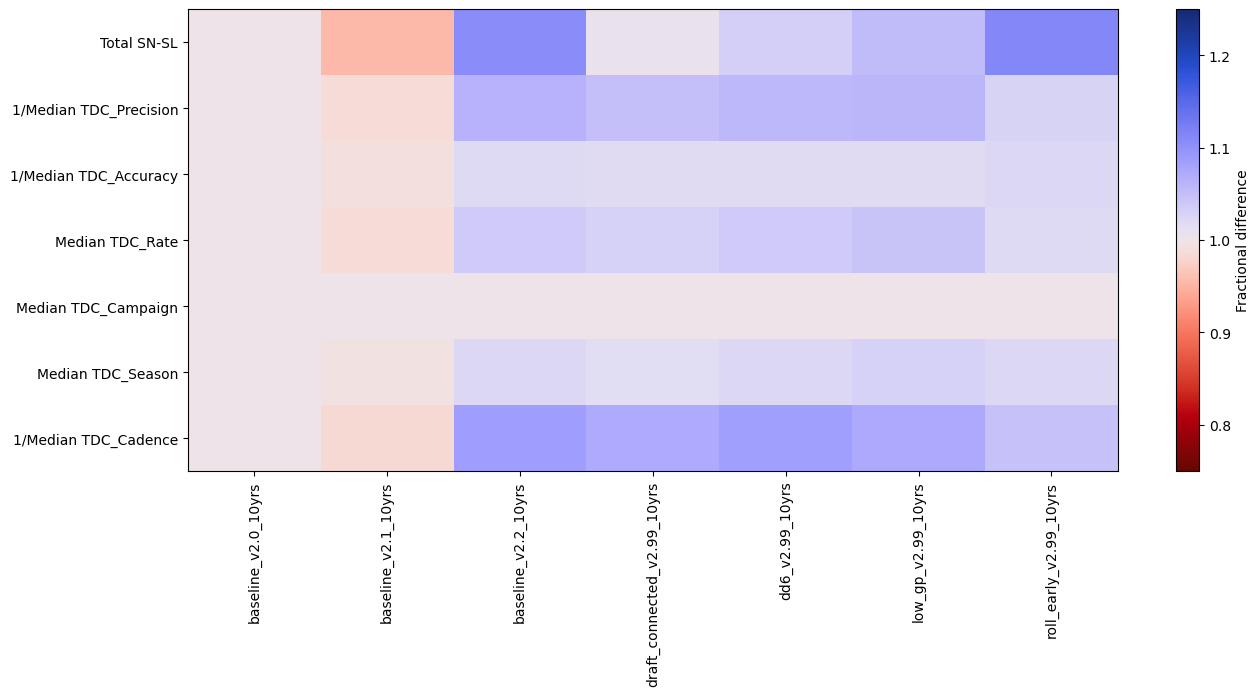

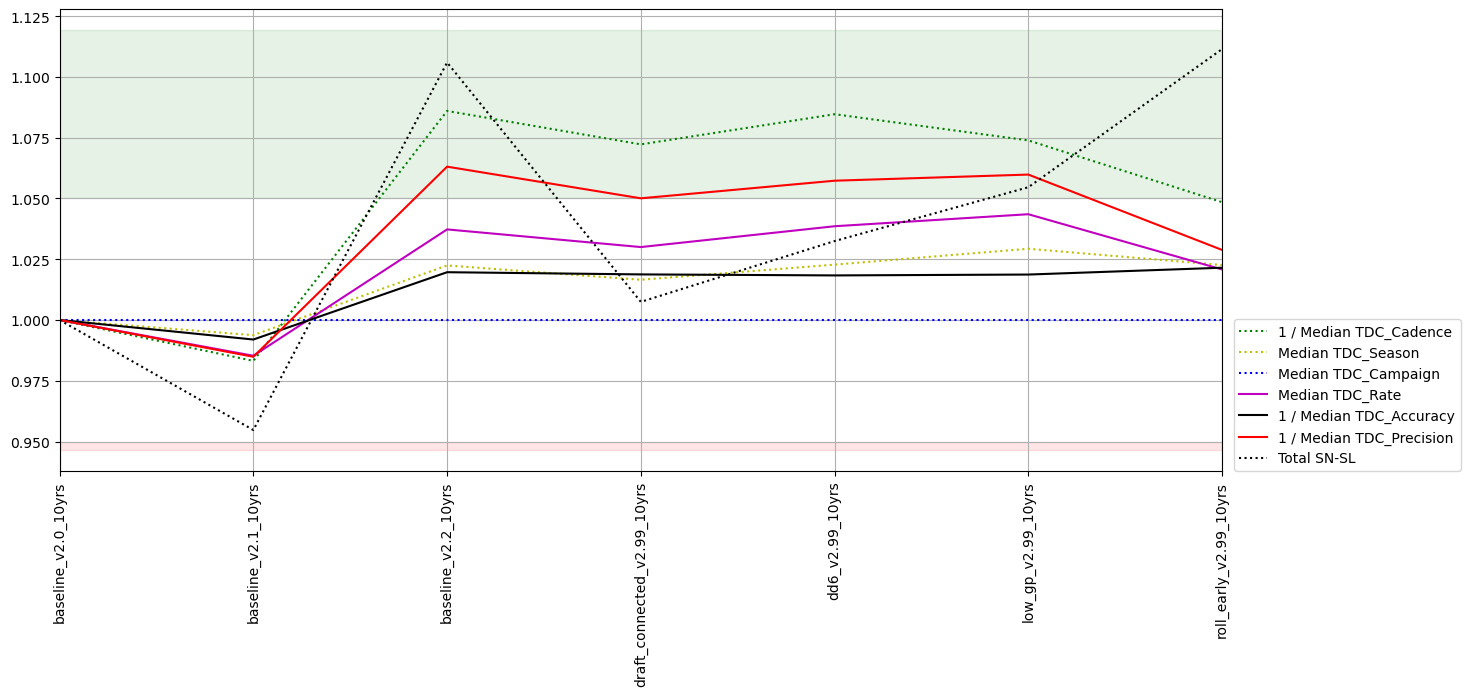

In [95]:
# StrongLensing metrics

k_sets = [k for k in msets if k.startswith('SL')]

msub = metric_sets.loc[k_sets].reset_index('metric set')
# Add the strong lensed supernova metric
msub = pd.concat([msub, 
                  metric_sets.loc['DESC WFD'].query('metric.str.contains("SNSL")', engine='python')])

fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                   baseline_run=baseline_run,
                                   metric_label_map=msub['short_name'],
                                   metric_set=msub,
                                  color_range=0.5)
fig.set_figwidth(15)



fig, ax = maf.plot_run_metric(summaries.loc[these_runs, msub['metric']], 
                              baseline_run=baseline_run,
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                             horizontal_quantity='run',
                             vertical_quantity='value')
fig.set_figwidth(15)
#ax.set_ylim(0.5, 1.5)
lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')


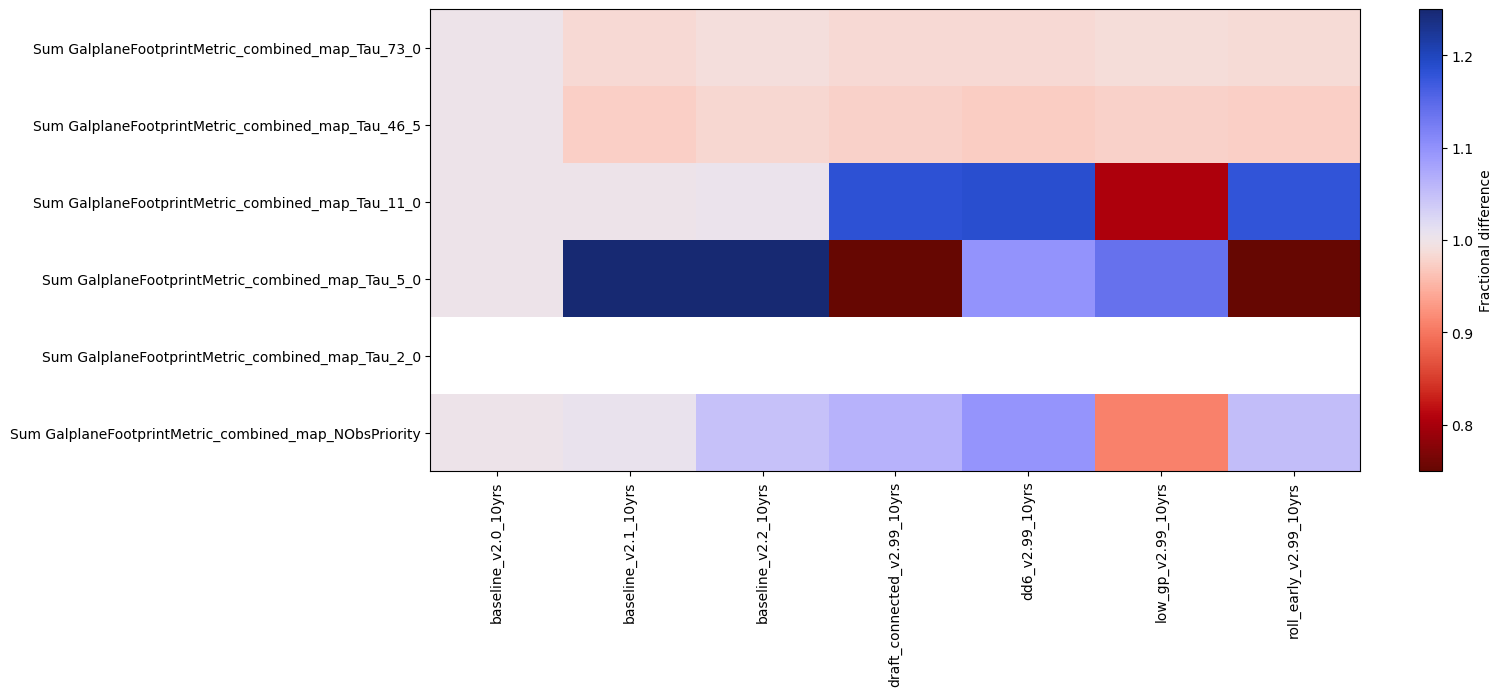

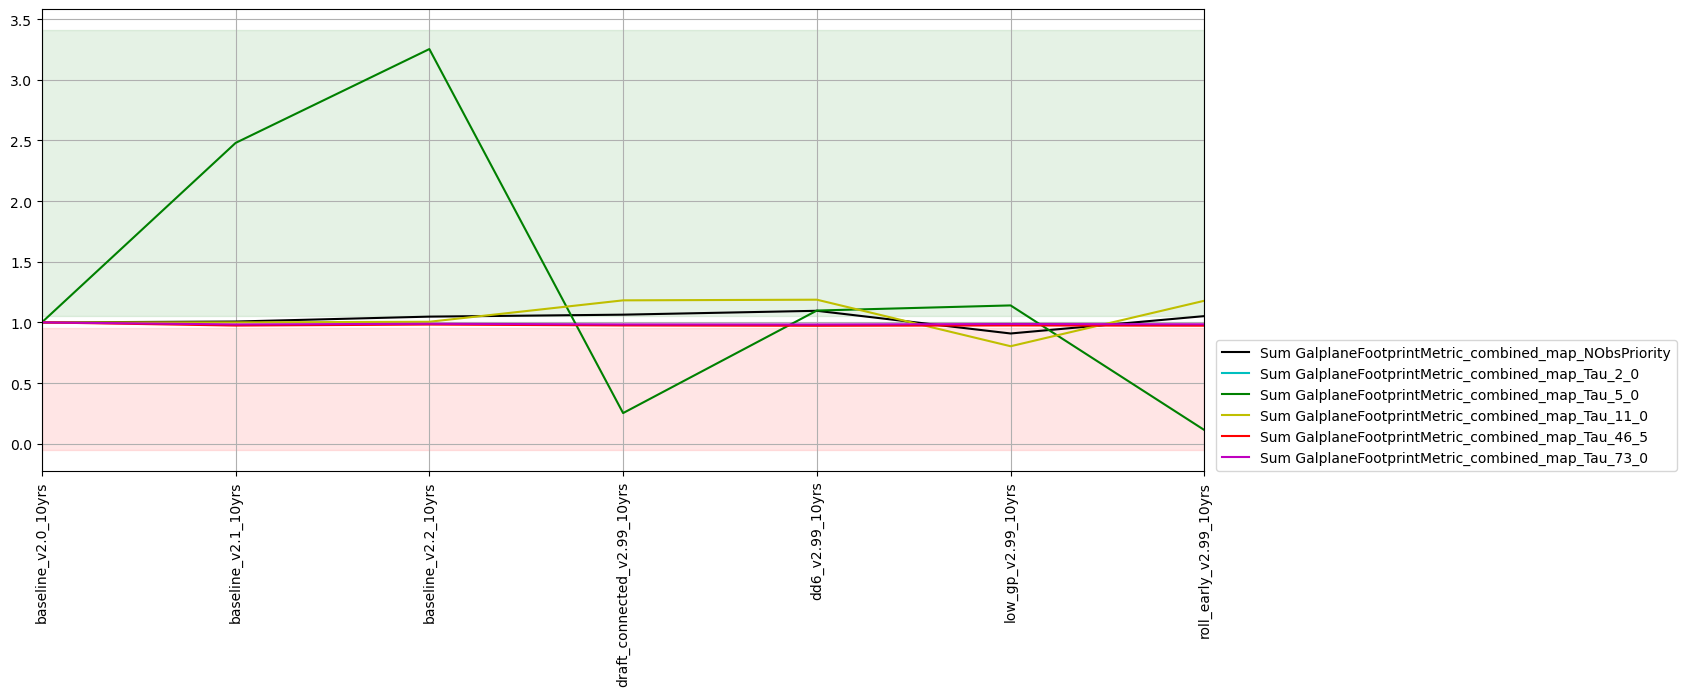

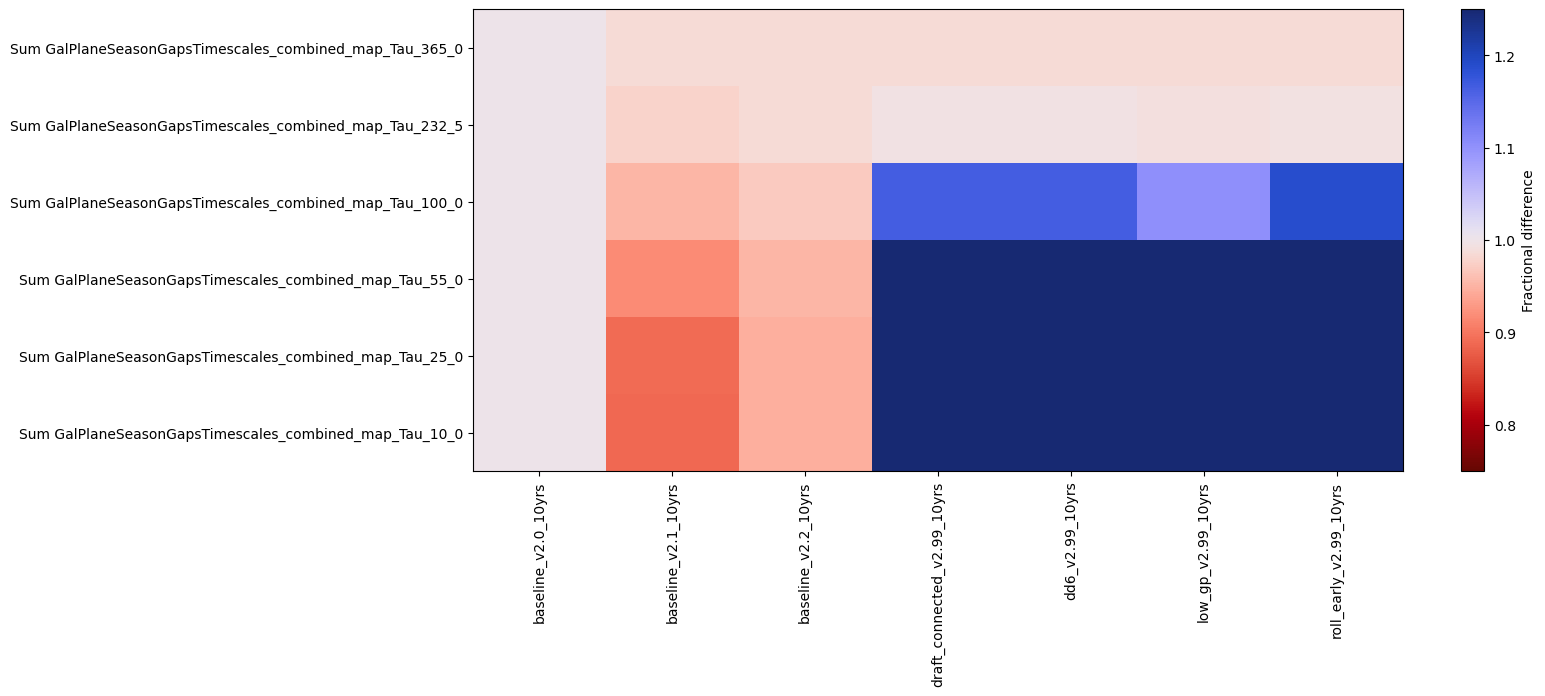

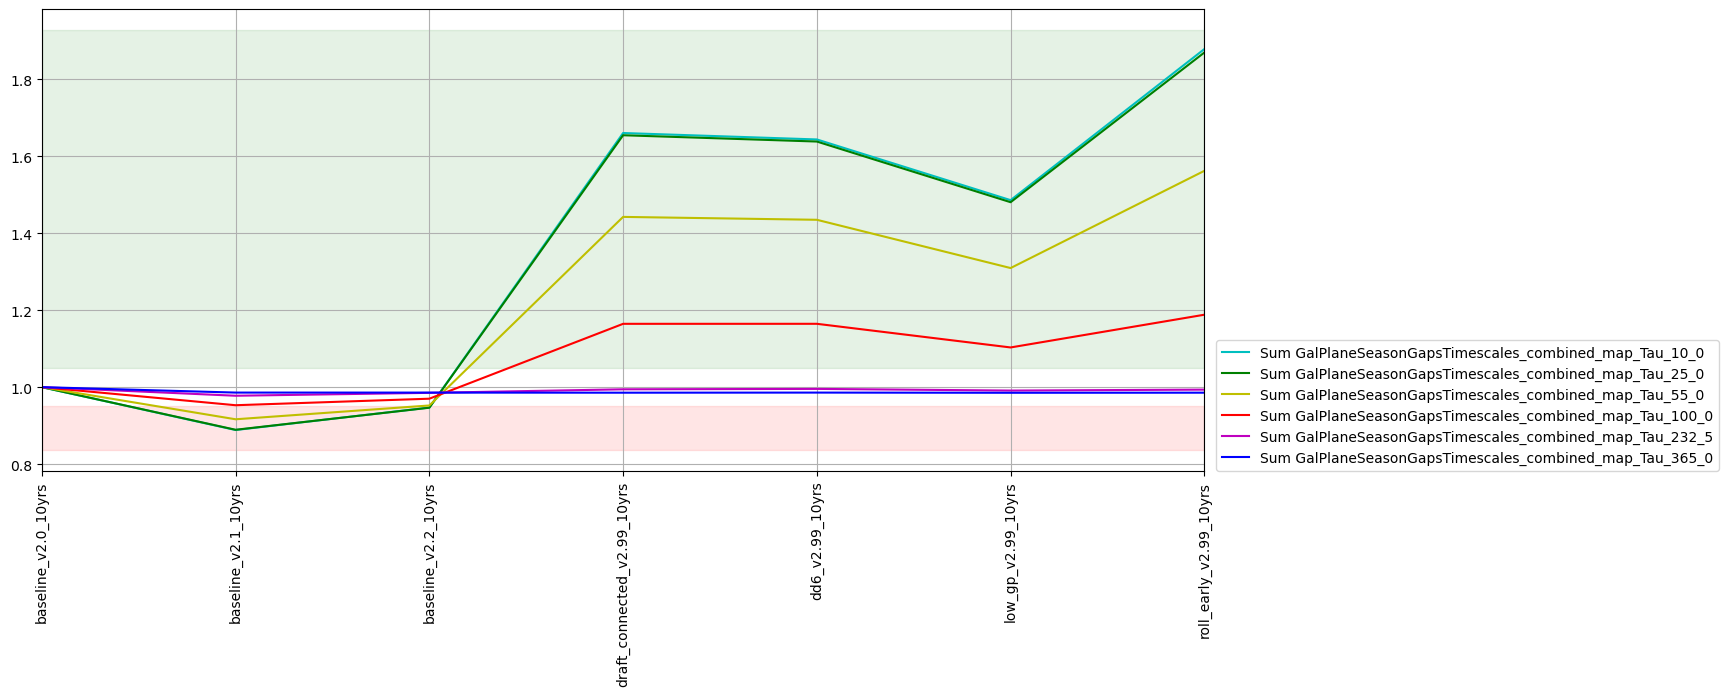

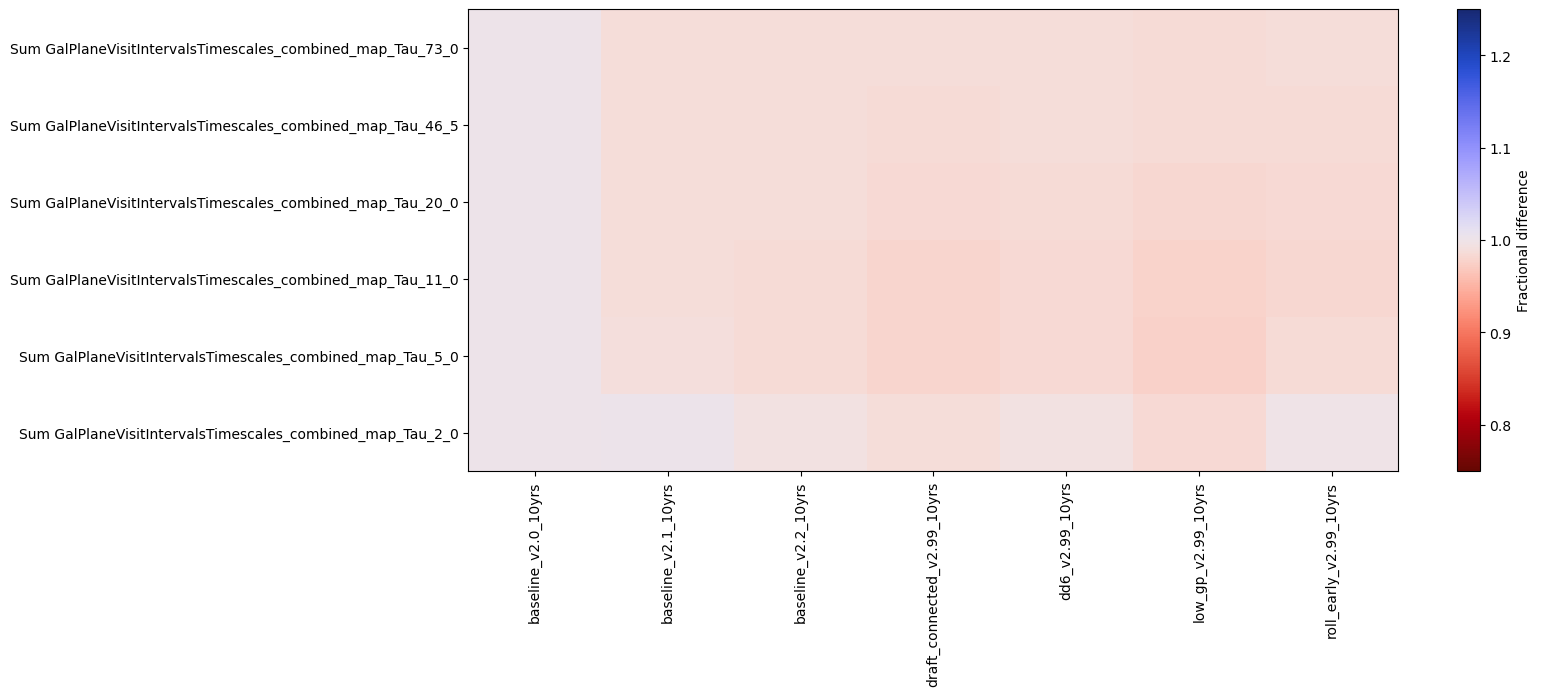

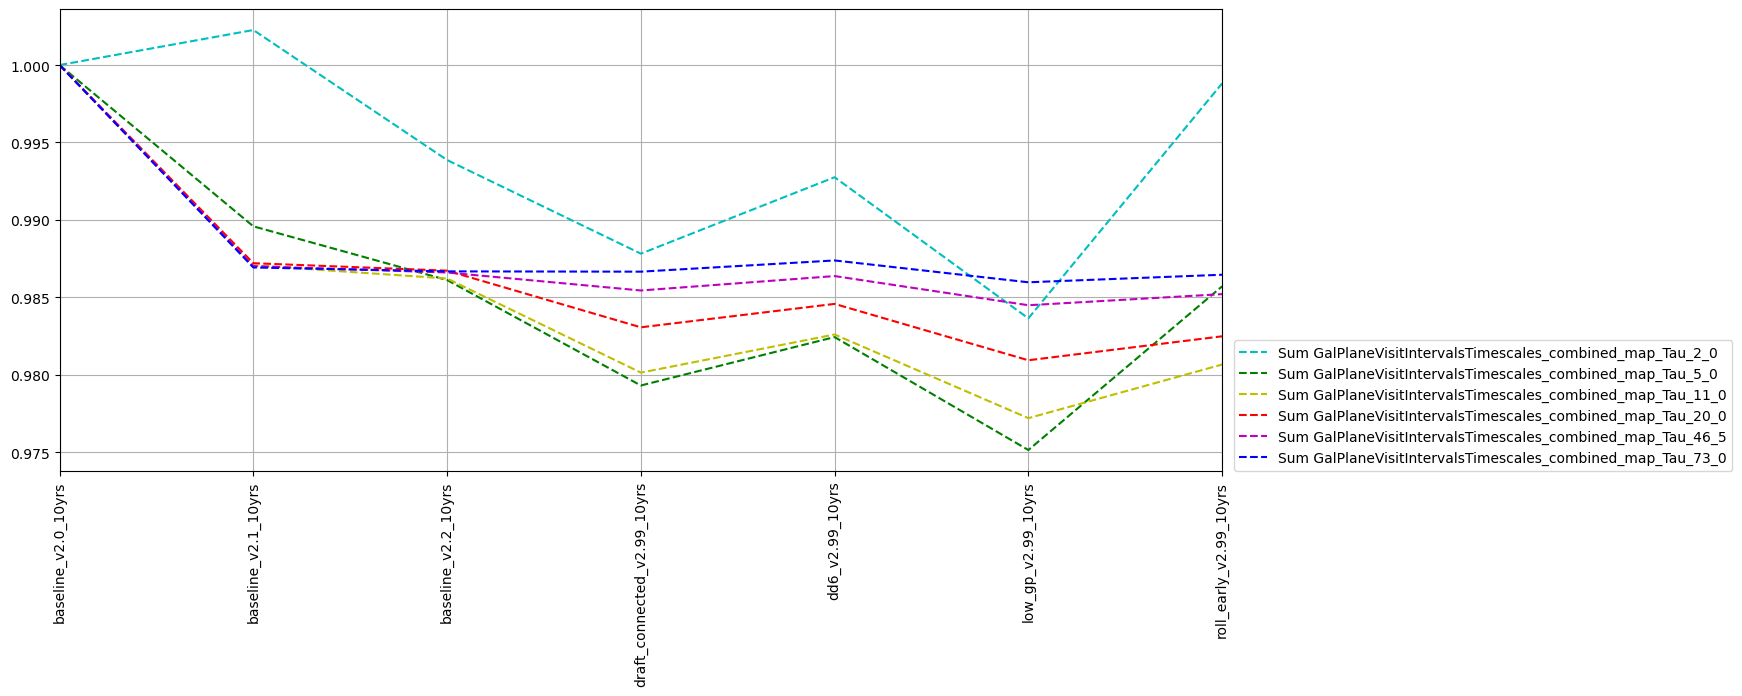

In [96]:
# GP footprint metrics
k_sets = [k for k in msets if k.startswith('GP') and 'filter' not in k]

for k in k_sets:
    msub = metric_sets.loc[k]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs,msub['metric']], 
                                       baseline_run=baseline_run,
                                       metric_label_map=msub['short_name'],
                                       metric_set=msub,
                                      color_range=0.5)
    fig.set_figwidth(15)


    fig, ax = maf.plot_run_metric(summaries.loc[these_runs, metric_sets.loc[k]['metric']], 
                                  baseline_run=baseline_run,
                                  metric_set=metric_sets.loc[k],
                                  metric_label_map=metric_sets.loc[k]['short_name'],
                                 horizontal_quantity='run',
                                 vertical_quantity='value')
    fig.set_figwidth(15)
    #ax.set_ylim(0.5, 1.5)
    lgd = plt.legend(loc=(1.01, 0.0), fancybox=True, numpoints=1, fontsize='medium')


Some of the trades above are due to DDF increases in time and adding the twilight NEO microsurvey, so let's check those benefits. 
(there are also trades due to changing the intranight cadence with triplets, but those should be reflected in the other metrics above, and likewise for the galactic plane footprint).

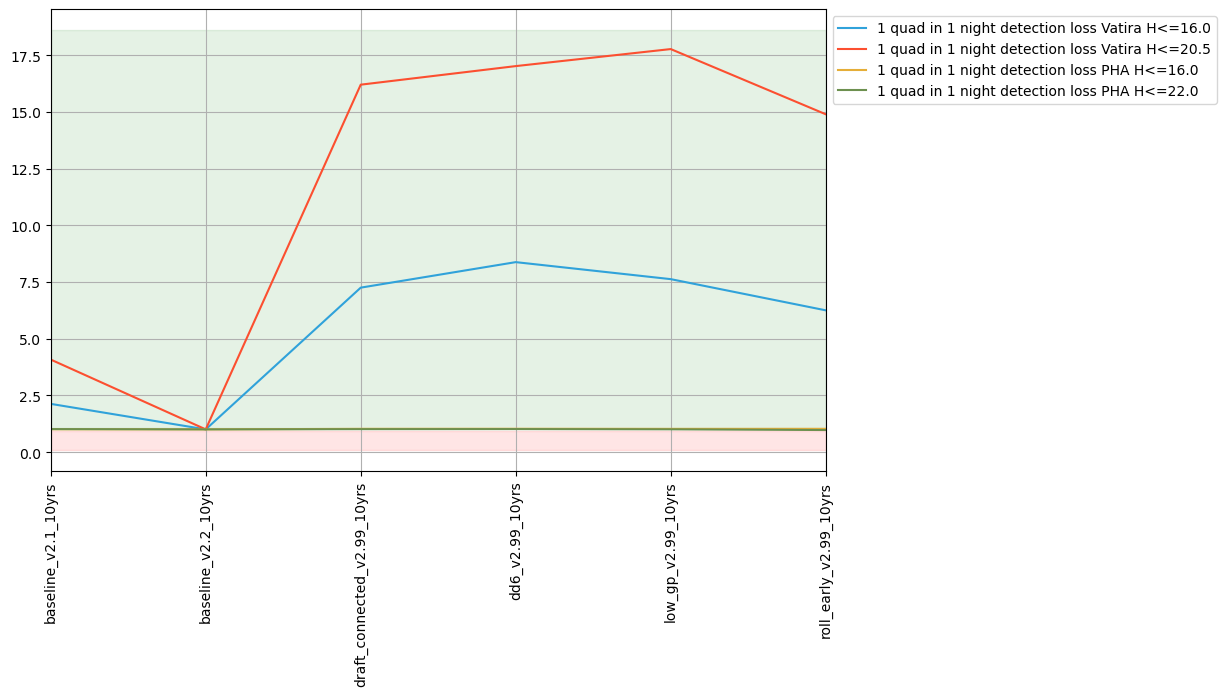

In [97]:
# microsurvey - vatira 
micro_discovery = [m for m in summaries if 'Vatira' in m and '1 quad in 1 night' in m ]
micro_discovery += [m for m in summaries if "PHA" in m and '1 quad in 1 night' in m and 'Nobj' not in m]

fig, ax = maf.plot_run_metric(summaries.loc[these_runs, micro_discovery].dropna(),
                            baseline_run='baseline_v2.2_10yrs',
                              linestyles=['-'],
                              markers=[''],
                             horizontal_quantity='run',
                             vertical_quantity='value')


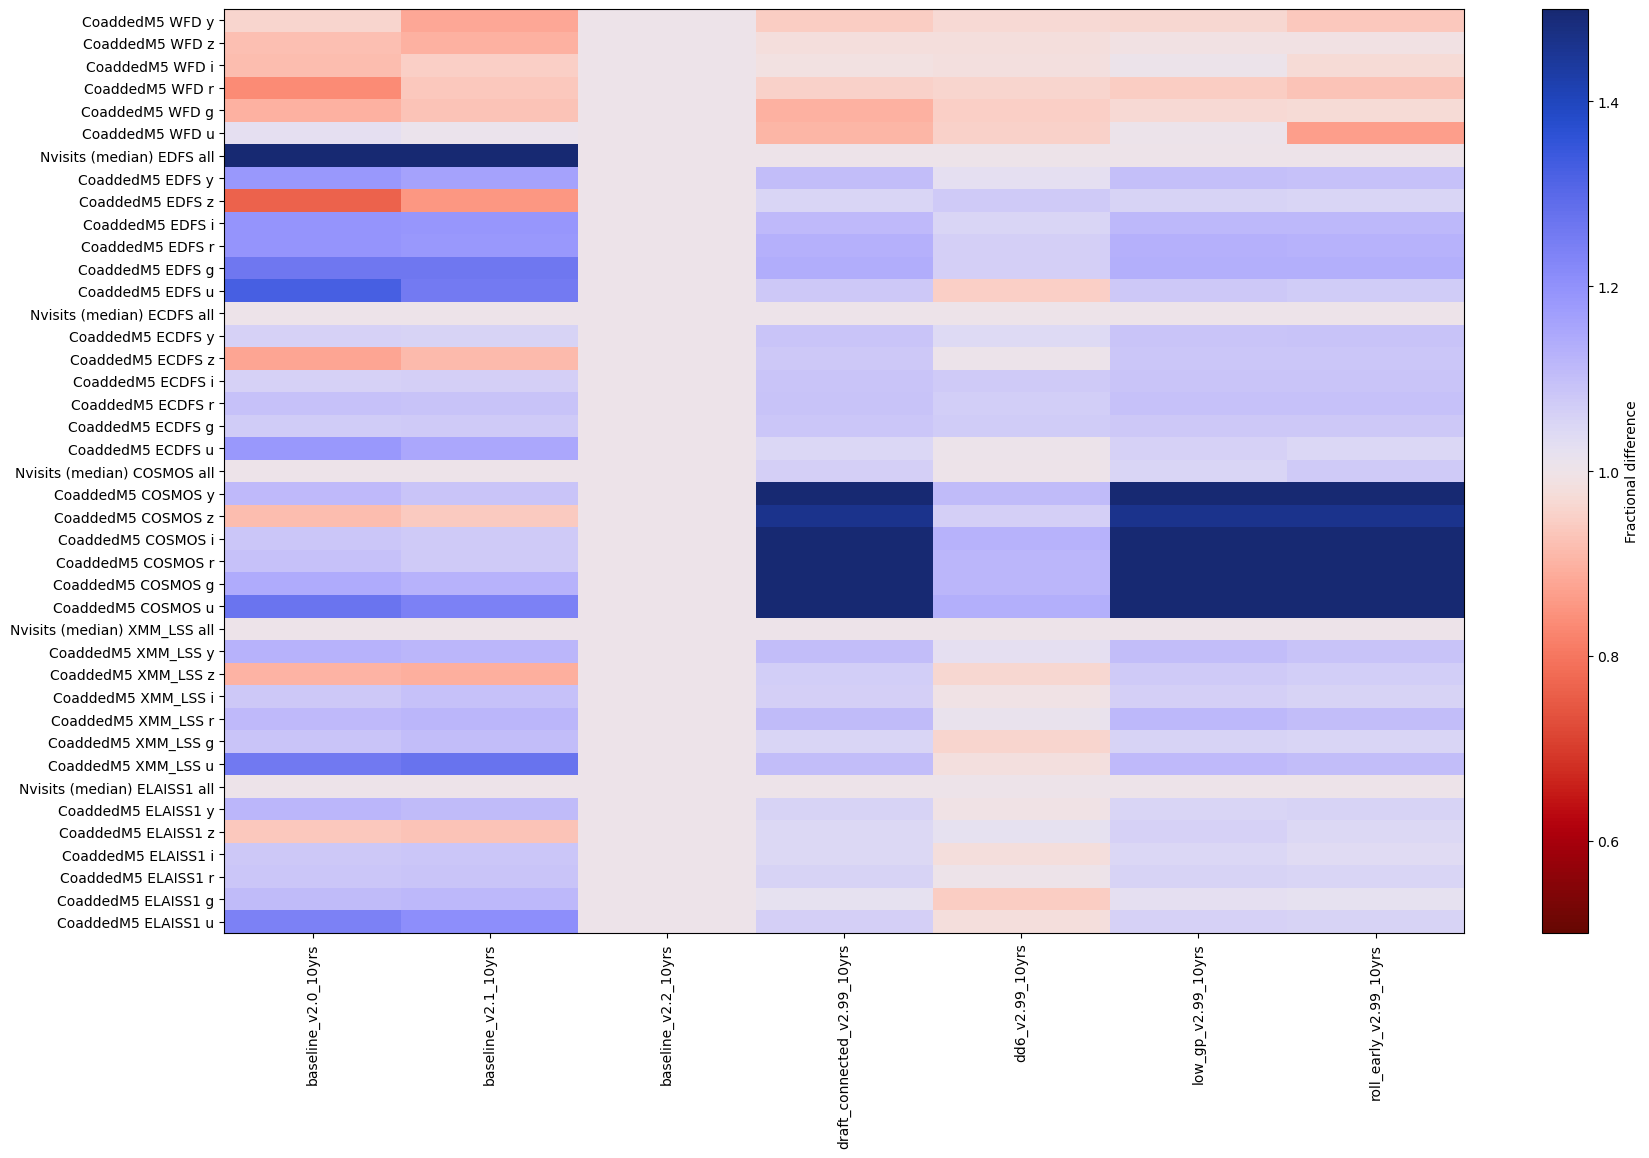

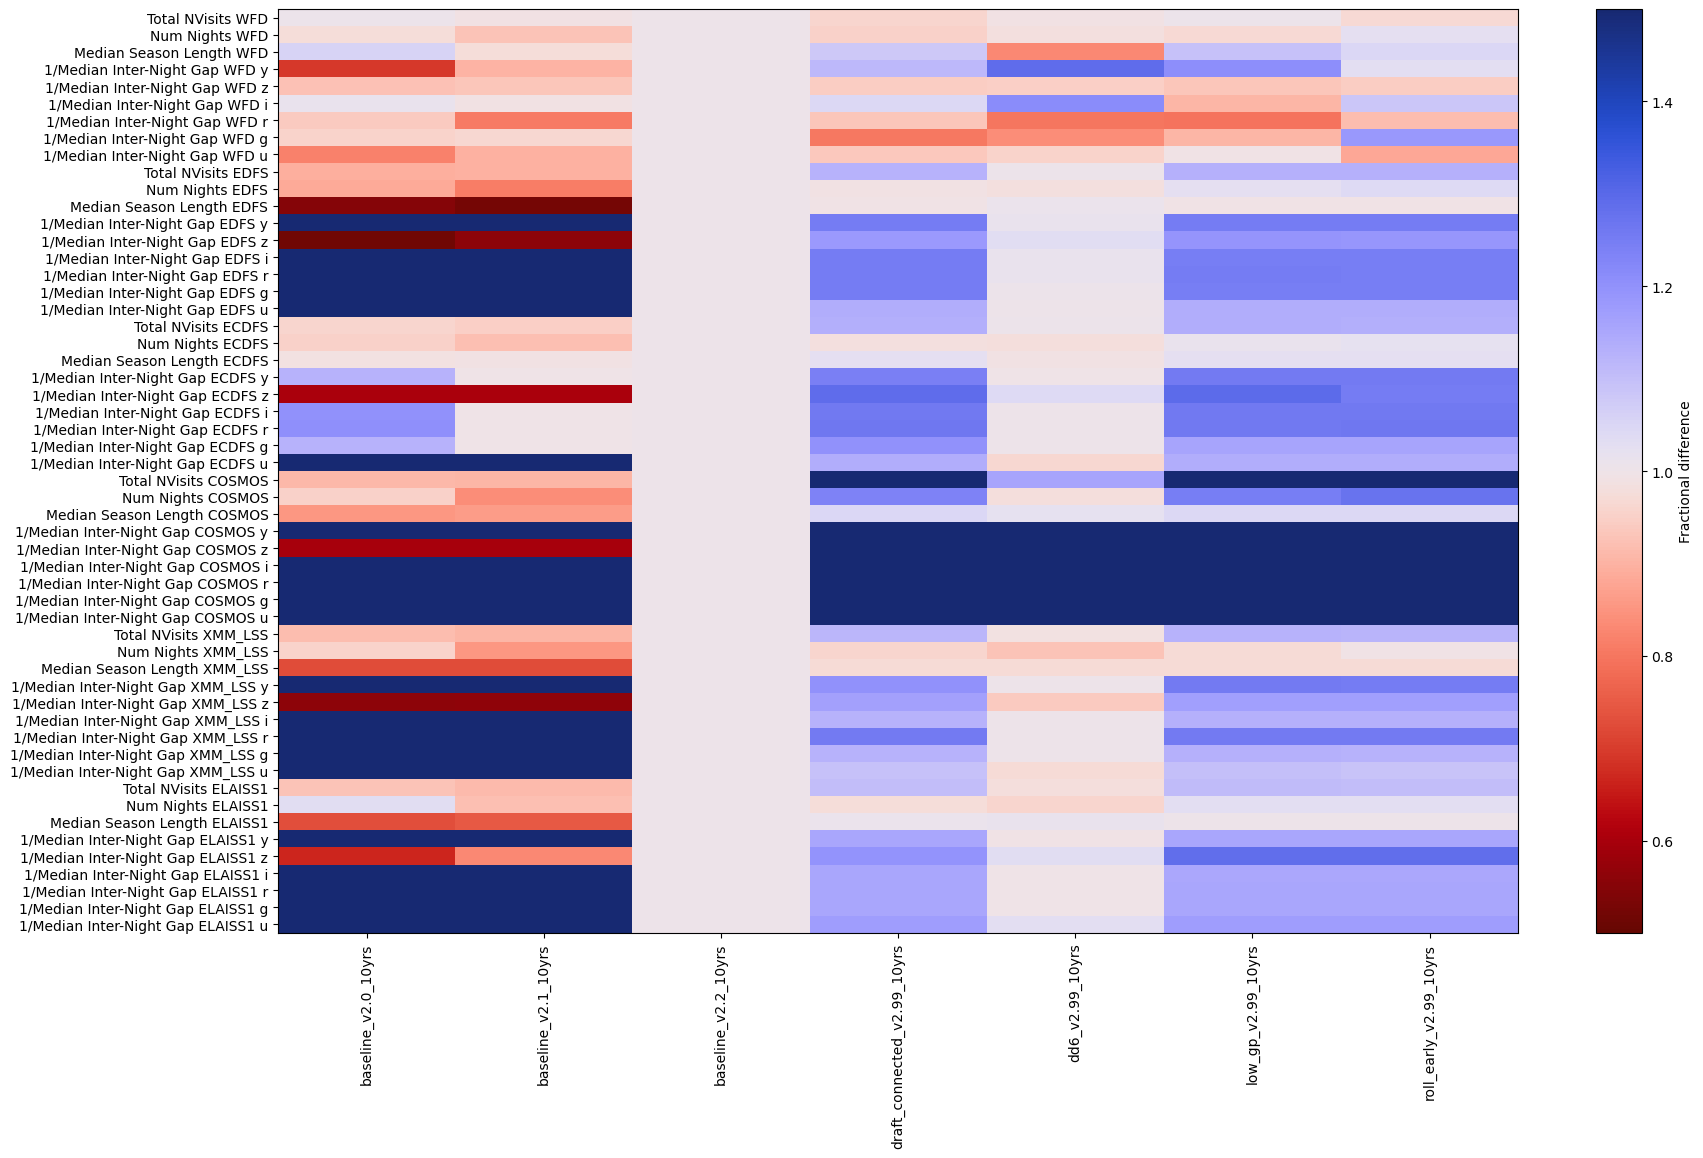

In [99]:
# DDF -- compare to v2.2 as this was the first version with pre-scheduled DDFs (v2.0/v2.1 are "non-prescheduled")
baseline = 'baseline_v2.2_10yrs'

for m in ['DDF Depths', 'DDF Cadence']:
    metrics = metric_sets.loc[m]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                      baseline_run=baseline,
                                      metric_label_map=metrics['short_name'],
                                      metric_set=metrics, 
                                      color_range=1)
    fig.set_figwidth(20)
    fig.set_figheight(12)


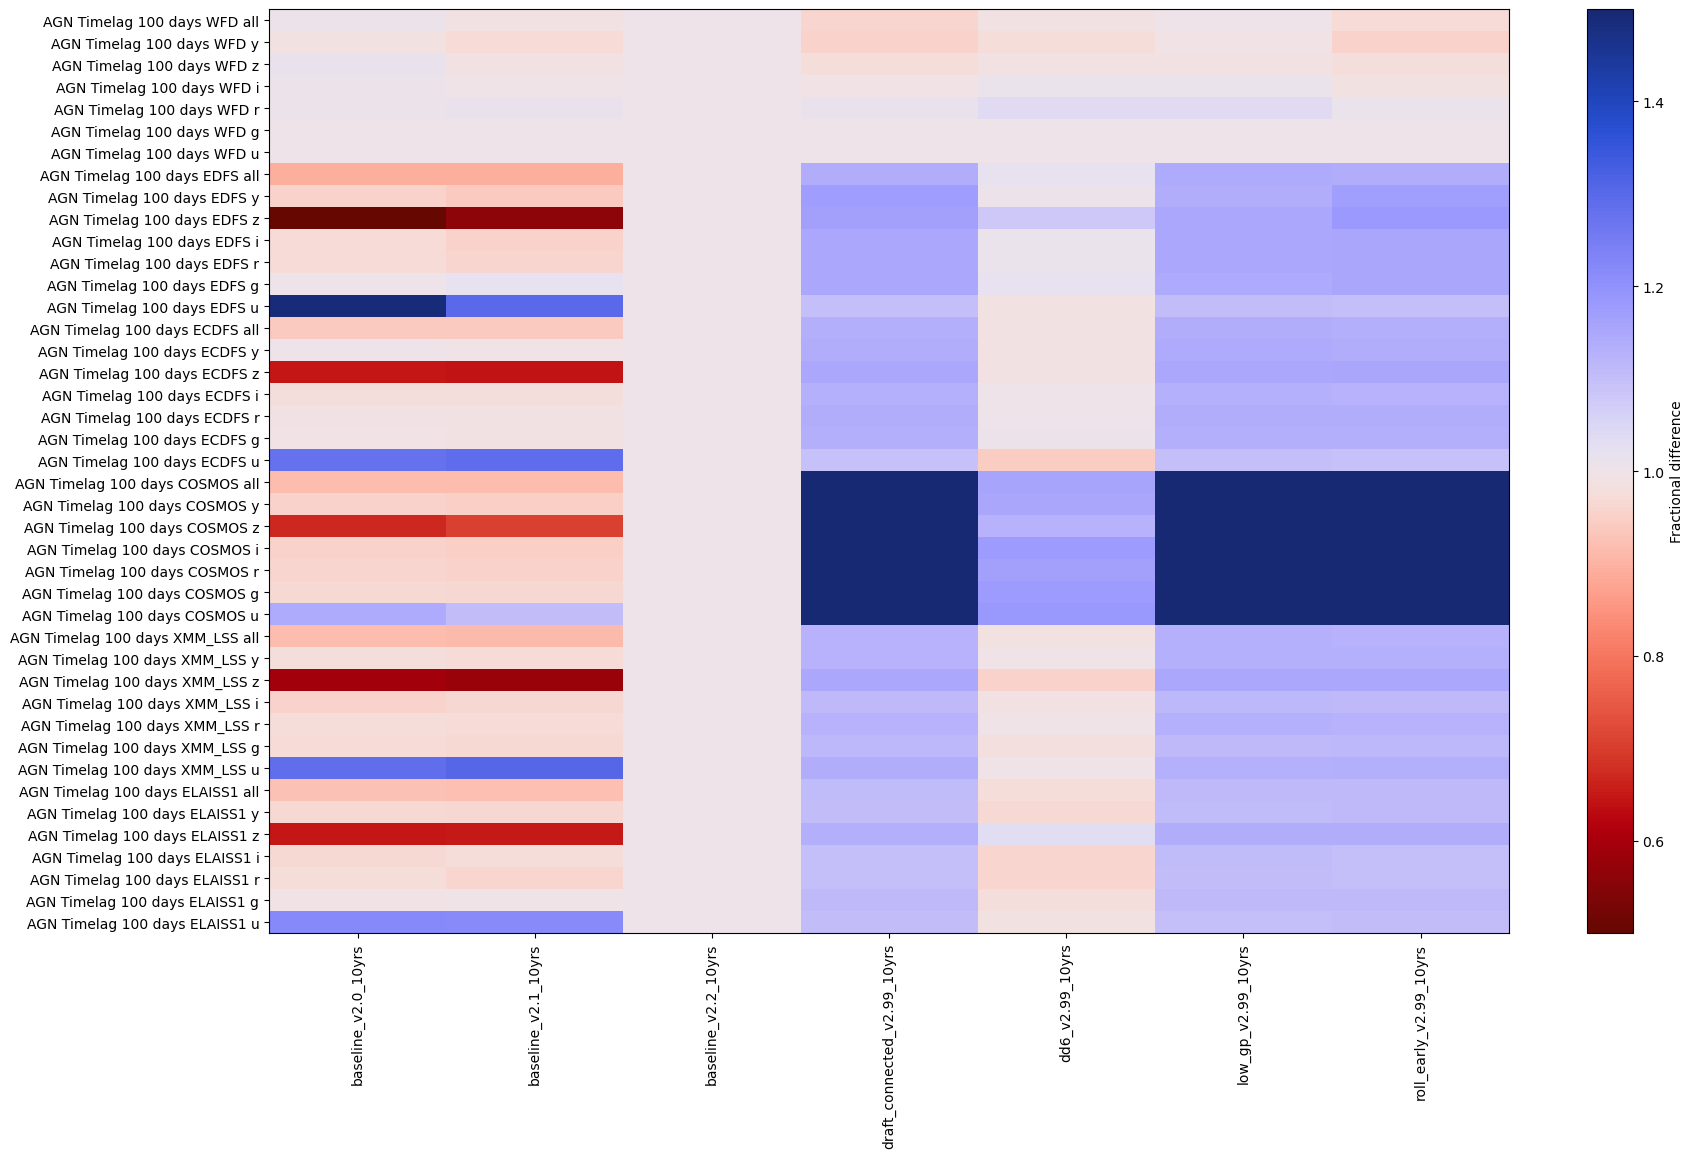

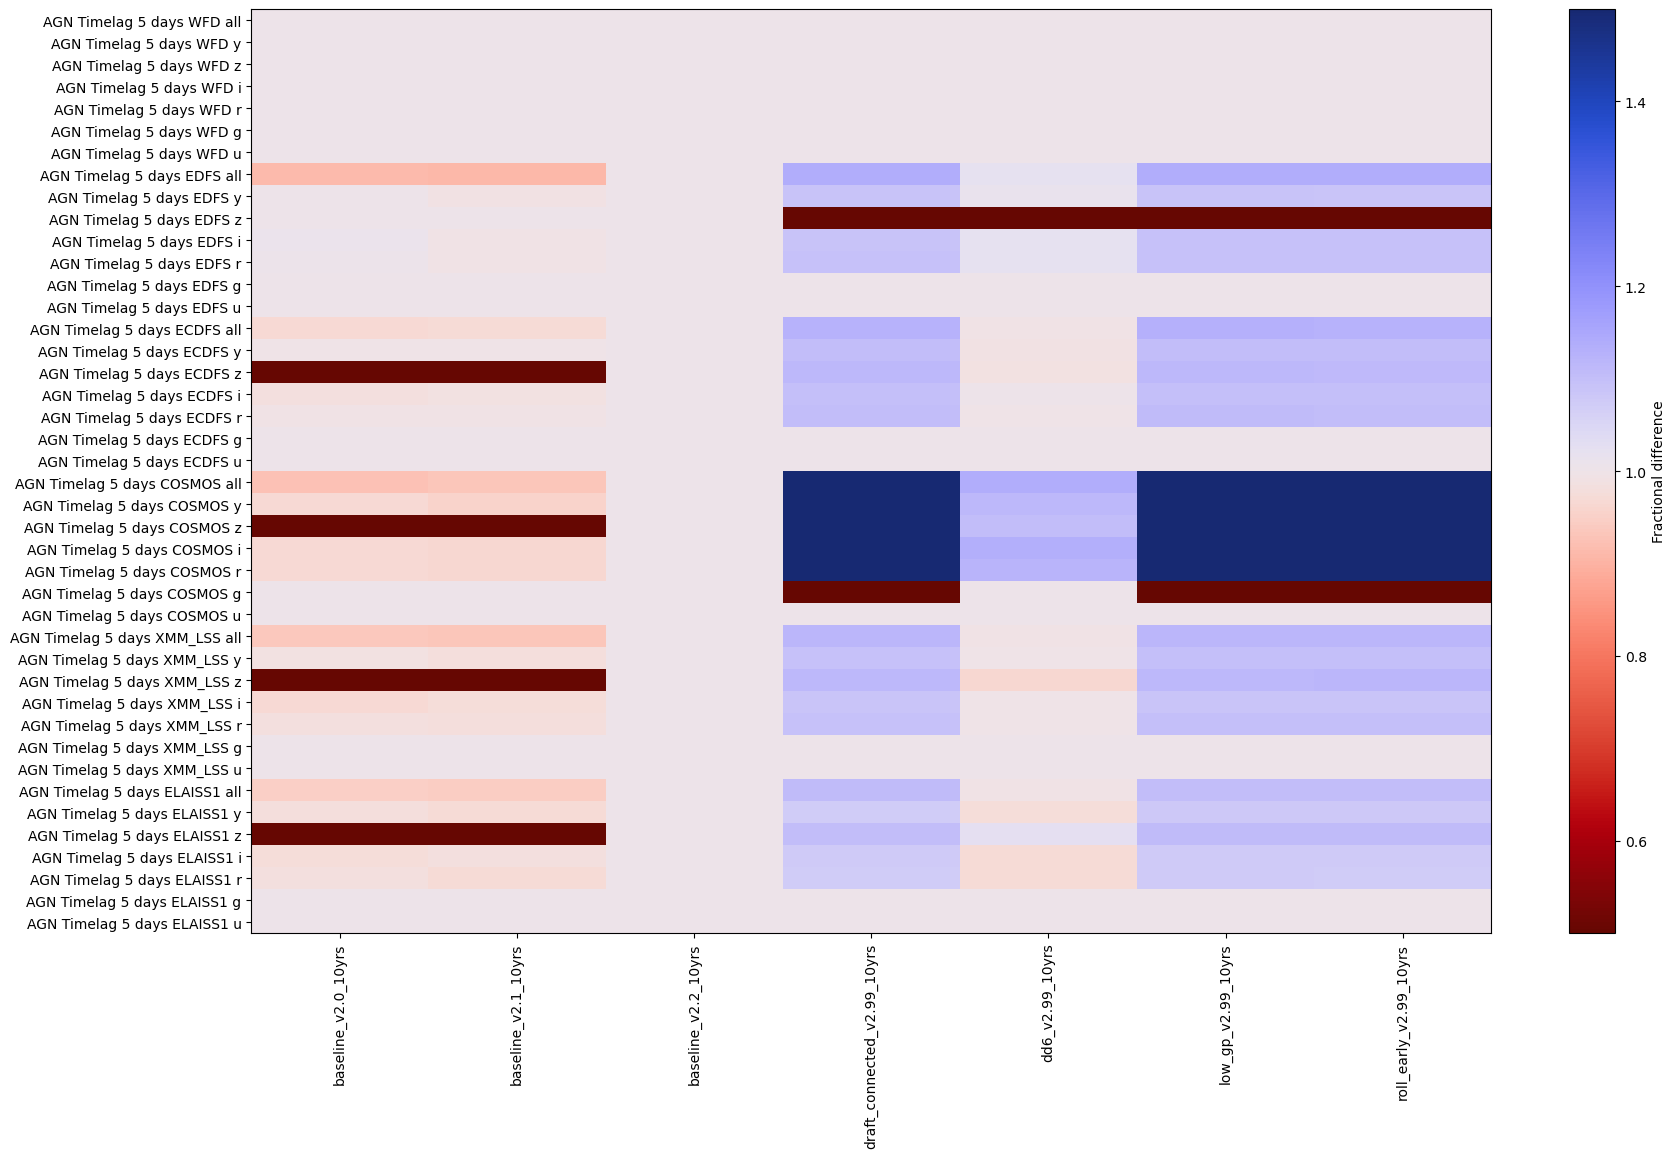

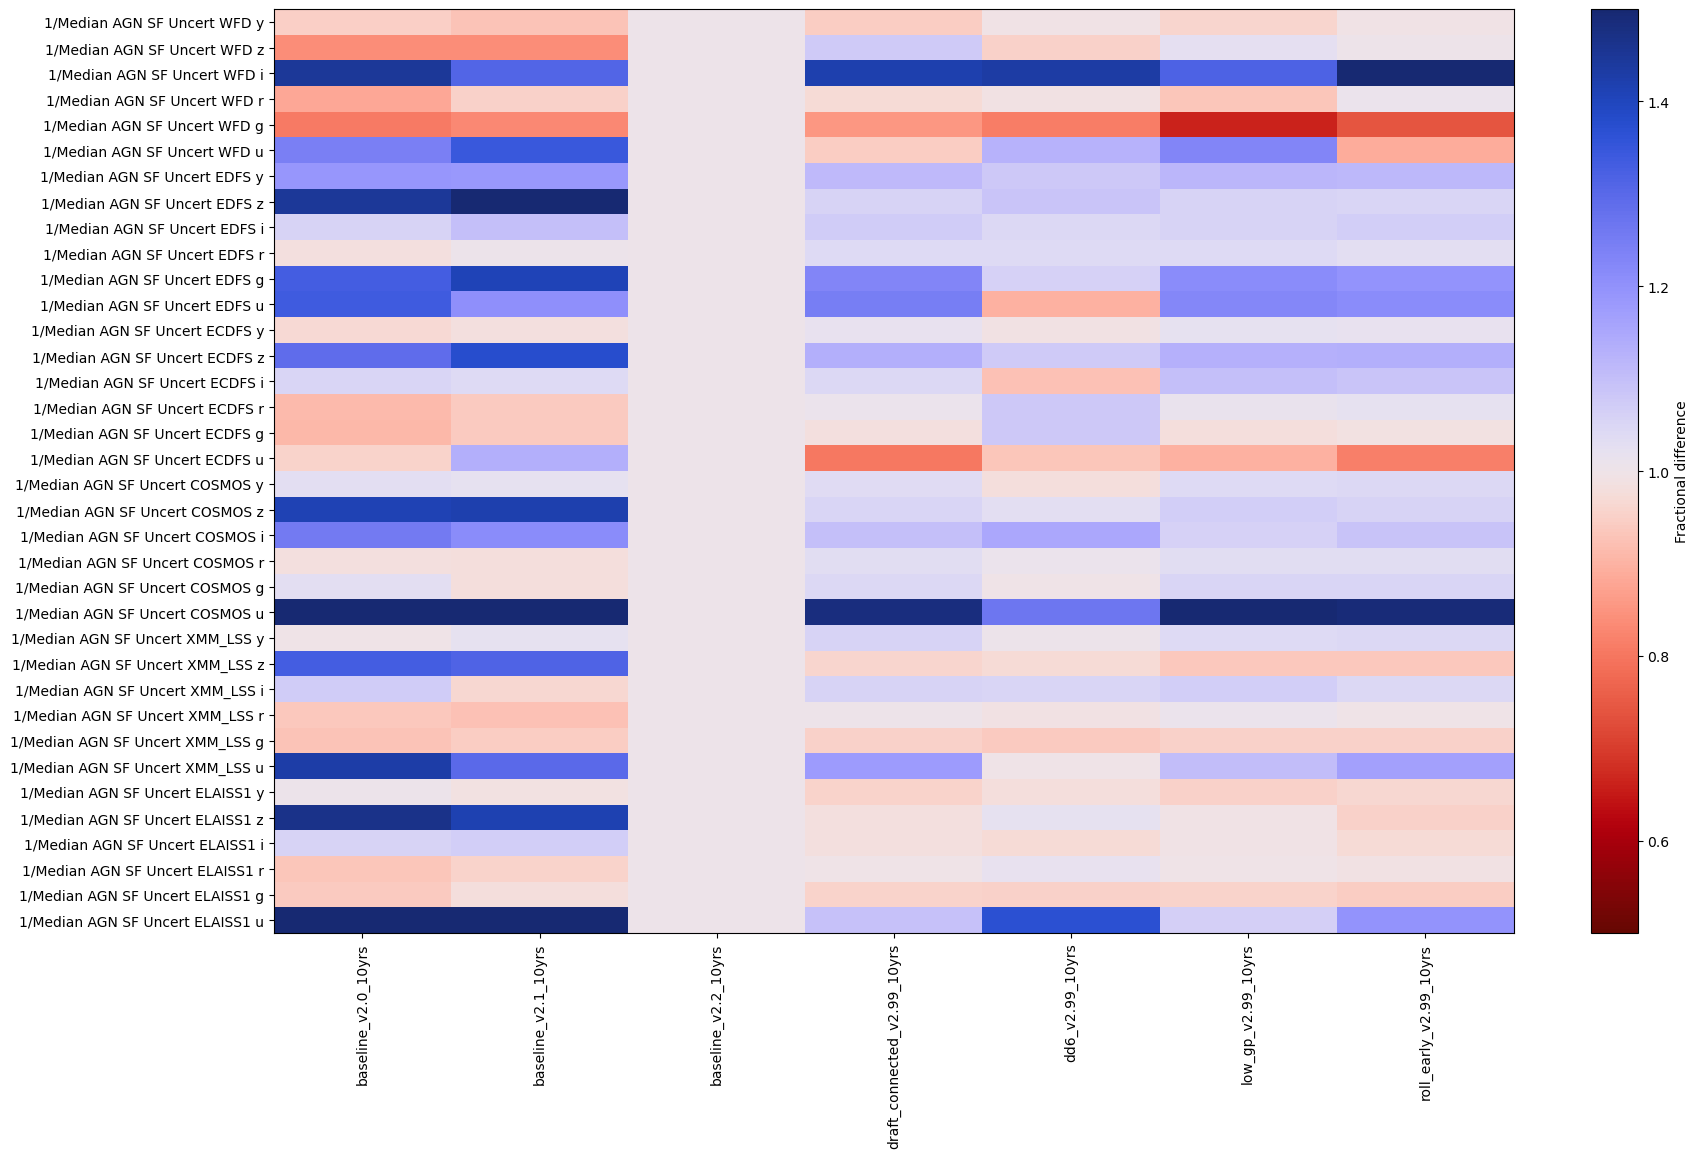

In [100]:
for m in ['AGN TimeLag 100 days DDF', 'AGN TimeLag 5 days DDF', 
          'AGN SF DDF']:
    metrics = metric_sets.loc[m]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                      baseline_run=baseline,
                                      metric_label_map=metrics['short_name'],
                                      metric_set=metrics, 
                                      color_range=1)
    fig.set_figwidth(20)
    fig.set_figheight(12)

metric                       Sum SNNSNMetric DD:ELAISS1_nSN DD:ELAISS1 all bands HealpixSubsetSlicer  \
run                                                                                                    
baseline_v2.0_10yrs                                                  81.438800                         
baseline_v2.1_10yrs                                                  40.212476                         
baseline_v2.2_10yrs                                                   3.753806                         
draft_connected_v2.99_10yrs                                          34.299888                         
dd6_v2.99_10yrs                                                       0.000000                         
low_gp_v2.99_10yrs                                                   41.570874                         
roll_early_v2.99_10yrs                                               41.184944                         

metric                       Median SNNSNMetric DD:ELAISS1_zlim DD:ELAISS1 all bands HealpixSubsetSlicer  \
run                                                                                                        
baseline_v2.0_10yrs                                                   0.593426                             
baseline_v2.1_10yrs                                                   0.594464                             
baseline_v2.2_10yrs                                                   0.600156                             
draft_connected_v2.99_10yrs                                           0.545990                             
dd6_v2.99_10yrs                                                       0.000000                             
low_gp_v2.99_10yrs                                                    0.547389                             
roll_early_v2.99_10yrs                                                0.546709                             

metric                       Mean DD:ELAISS1 Median Inter-Night Gap r band UserPointsSlicer  \
run                                                                                           
baseline_v2.0_10yrs                                                   2.979590                
baseline_v2.1_10yrs                                                   2.997909                
baseline_v2.2_10yrs                                                   8.976109                
draft_connected_v2.99_10yrs                                           7.769368                
dd6_v2.99_10yrs                                                       8.995575                
low_gp_v2.99_10yrs                                                    7.785121                
roll_early_v2.99_10yrs                                                7.789126                

metric                       Mean DD:ELAISS1 Median Season Length all bands UserPointsSlicer  \
run                                                                                            
baseline_v2.0_10yrs                                                 147.728578                 
baseline_v2.1_10yrs                                                 151.686350                 
baseline_v2.2_10yrs                                                 202.775236                 
draft_connected_v2.99_10yrs                                         204.645461                 
dd6_v2.99_10yrs                                                     205.841330                 
low_gp_v2.99_10yrs                                                  202.884877                 
roll_early_v2.99_10yrs                                              202.875559                 

metric                       Sum SNNSNMetric DD:XMM_LSS_nSN DD:XMM_LSS all bands HealpixSubsetSlicer  \
run                                                                                                    
baseline_v2.0_10yrs                                                   0.000000                         
baseline_v2.1_10yrs                                      

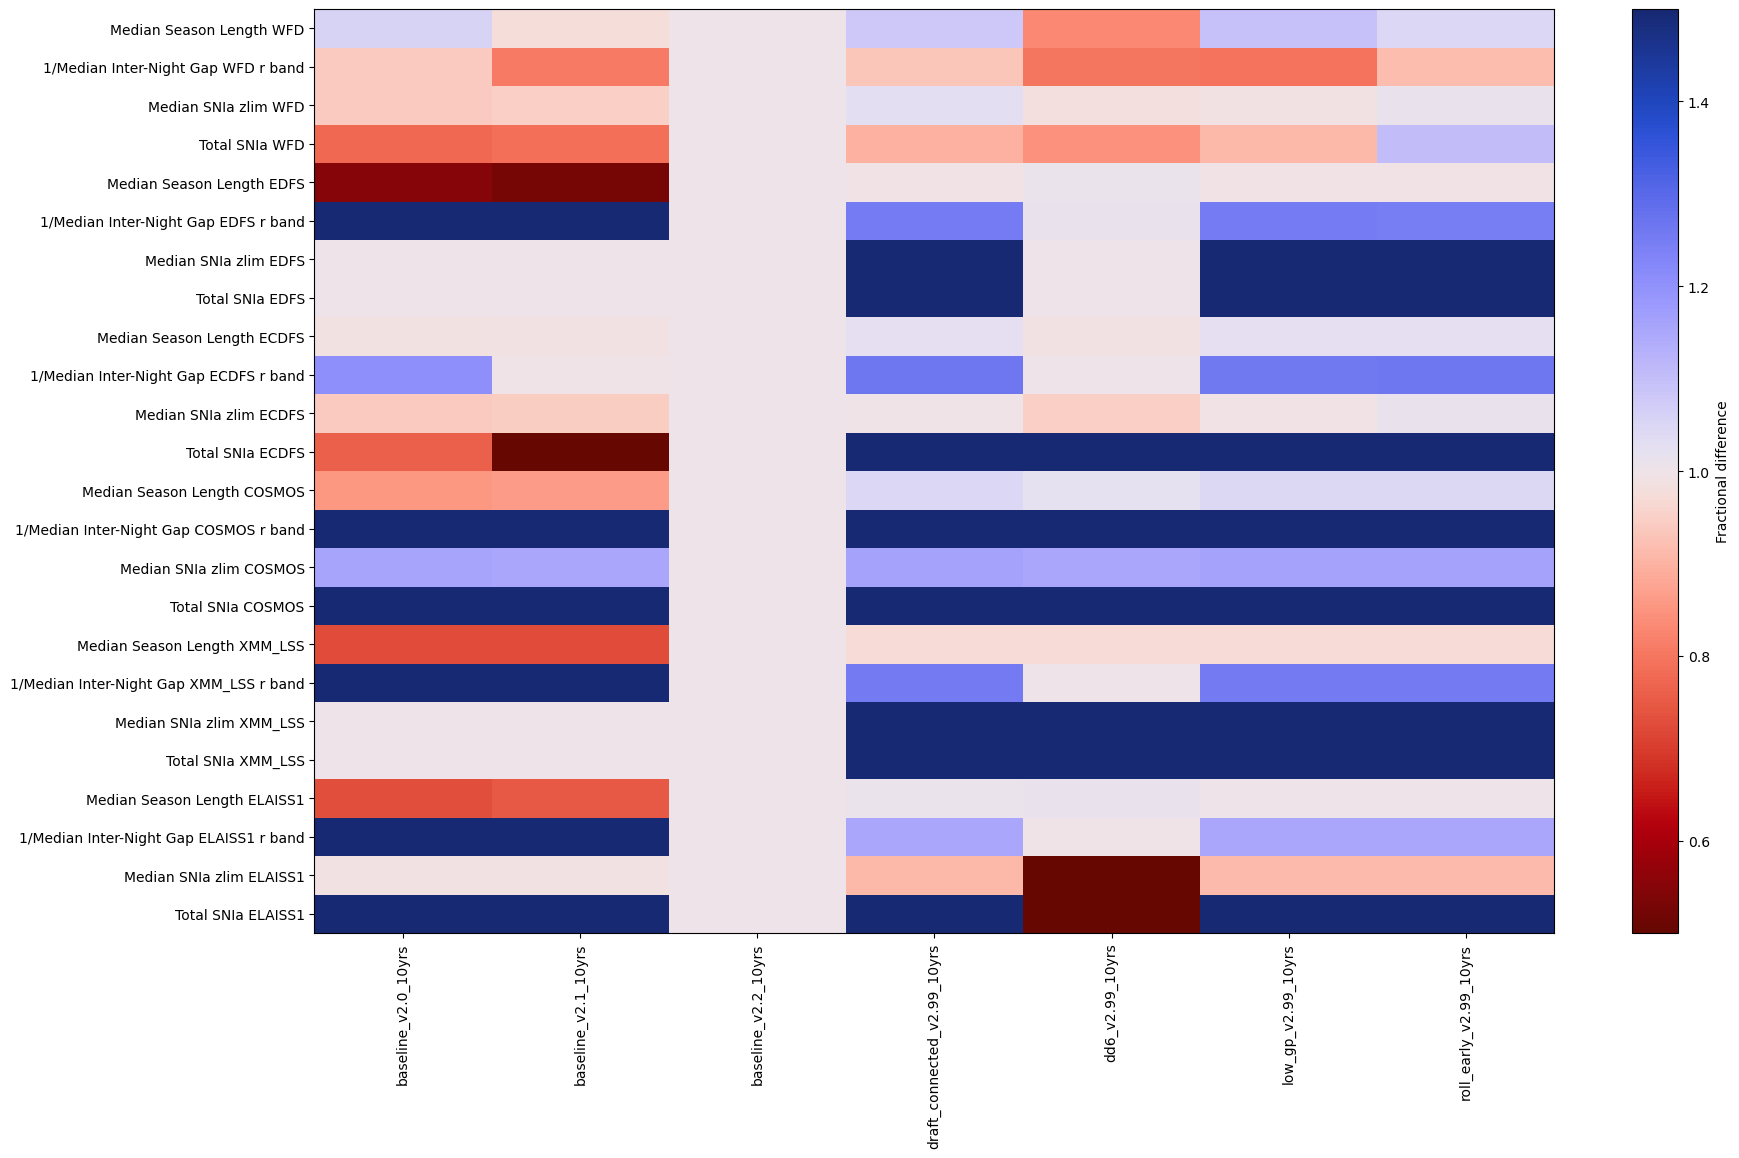

In [109]:
m = 'SNIa DDF'

metrics = metric_sets.loc[m]
# the SN summary values default to -1.6e30 for 'bad values' but this screws up normalization, so replace.
t = summaries.loc[these_runs, metrics['metric']].copy()
t[t < 0] = 1e-30

metrics = metric_sets.loc[m]
fig, ax = maf.plot_run_metric_mesh(t,
                                  baseline_run=baseline,
                                  metric_label_map=metrics['short_name'],
                                  metric_set=metrics, 
                                  color_range=1)
fig.set_figwidth(20)
fig.set_figheight(12)
    
t = summaries.loc[these_runs, metric_sets.loc['SNIa DDF']['metric']].copy()
t[t < 0] = 0
t

metric                       Sum SNSLMetric DD:ELAISS1 all bands HealpixSubsetSlicer  \
run                                                                                    
baseline_v2.0_10yrs                                                   0.015108         
baseline_v2.1_10yrs                                                   0.013812         
baseline_v2.2_10yrs                                                   0.013993         
draft_connected_v2.99_10yrs                                           0.013139         
dd6_v2.99_10yrs                                                       0.013549         
low_gp_v2.99_10yrs                                                    0.014230         
roll_early_v2.99_10yrs                                                0.014772         

metric                       Sum SNSLMetric DD:XMM_LSS all bands HealpixSubsetSlicer  \
run                                                                                    
baseline_v2.0_10yrs                                                   0.014272         
baseline_v2.1_10yrs                                                   0.013001         
baseline_v2.2_10yrs                                                   0.014243         
draft_connected_v2.99_10yrs                                           0.013669         
dd6_v2.99_10yrs                                                       0.012668         
low_gp_v2.99_10yrs                                                    0.013412         
roll_early_v2.99_10yrs                                                0.014703         

metric                       Sum SNSLMetric DD:COSMOS all bands HealpixSubsetSlicer  \
run                                                                                   
baseline_v2.0_10yrs                                                   0.014076        
baseline_v2.1_10yrs                                                   0.012324        
baseline_v2.2_10yrs                                                   0.014460        
draft_connected_v2.99_10yrs                                           0.018334        
dd6_v2.99_10yrs                                                       0.013877        
low_gp_v2.99_10yrs                                                    0.018918        
roll_early_v2.99_10yrs                                                0.018517        

metric                       Sum SNSLMetric DD:ECDFS all bands HealpixSubsetSlicer  \
run                                                                                  
baseline_v2.0_10yrs                                                   0.014287       
baseline_v2.1_10yrs                                                   0.013522       
baseline_v2.2_10yrs                                                   0.014000       
draft_connected_v2.99_10yrs                                           0.013325       
dd6_v2.99_10yrs                                                       0.012821       
low_gp_v2.99_10yrs                                                    0.013692       
roll_early_v2.99_10yrs                                                0.013550       

metric                       Sum SNSLMetric DD:EDFS all bands HealpixSubsetSlicer  \
run                                                                                 
baseline_v2.0_10yrs                                                   0.023664      
baseline_v2.1_10yrs                                                   0.024114      
baseline_v2.2_10yrs                                                   0.027733      
draft_connected_v2.99_10yrs                                           0.025336      
dd6_v2.99_10yrs                                                       0.026534      
low_gp_v2.99_10yrs                                                    0.026091      
roll_early_v2.99_10yrs                                                0.027485      

metric                       Sum SNSLMetric DD:WFD all bands HealpixSubsetSlicer  
run   

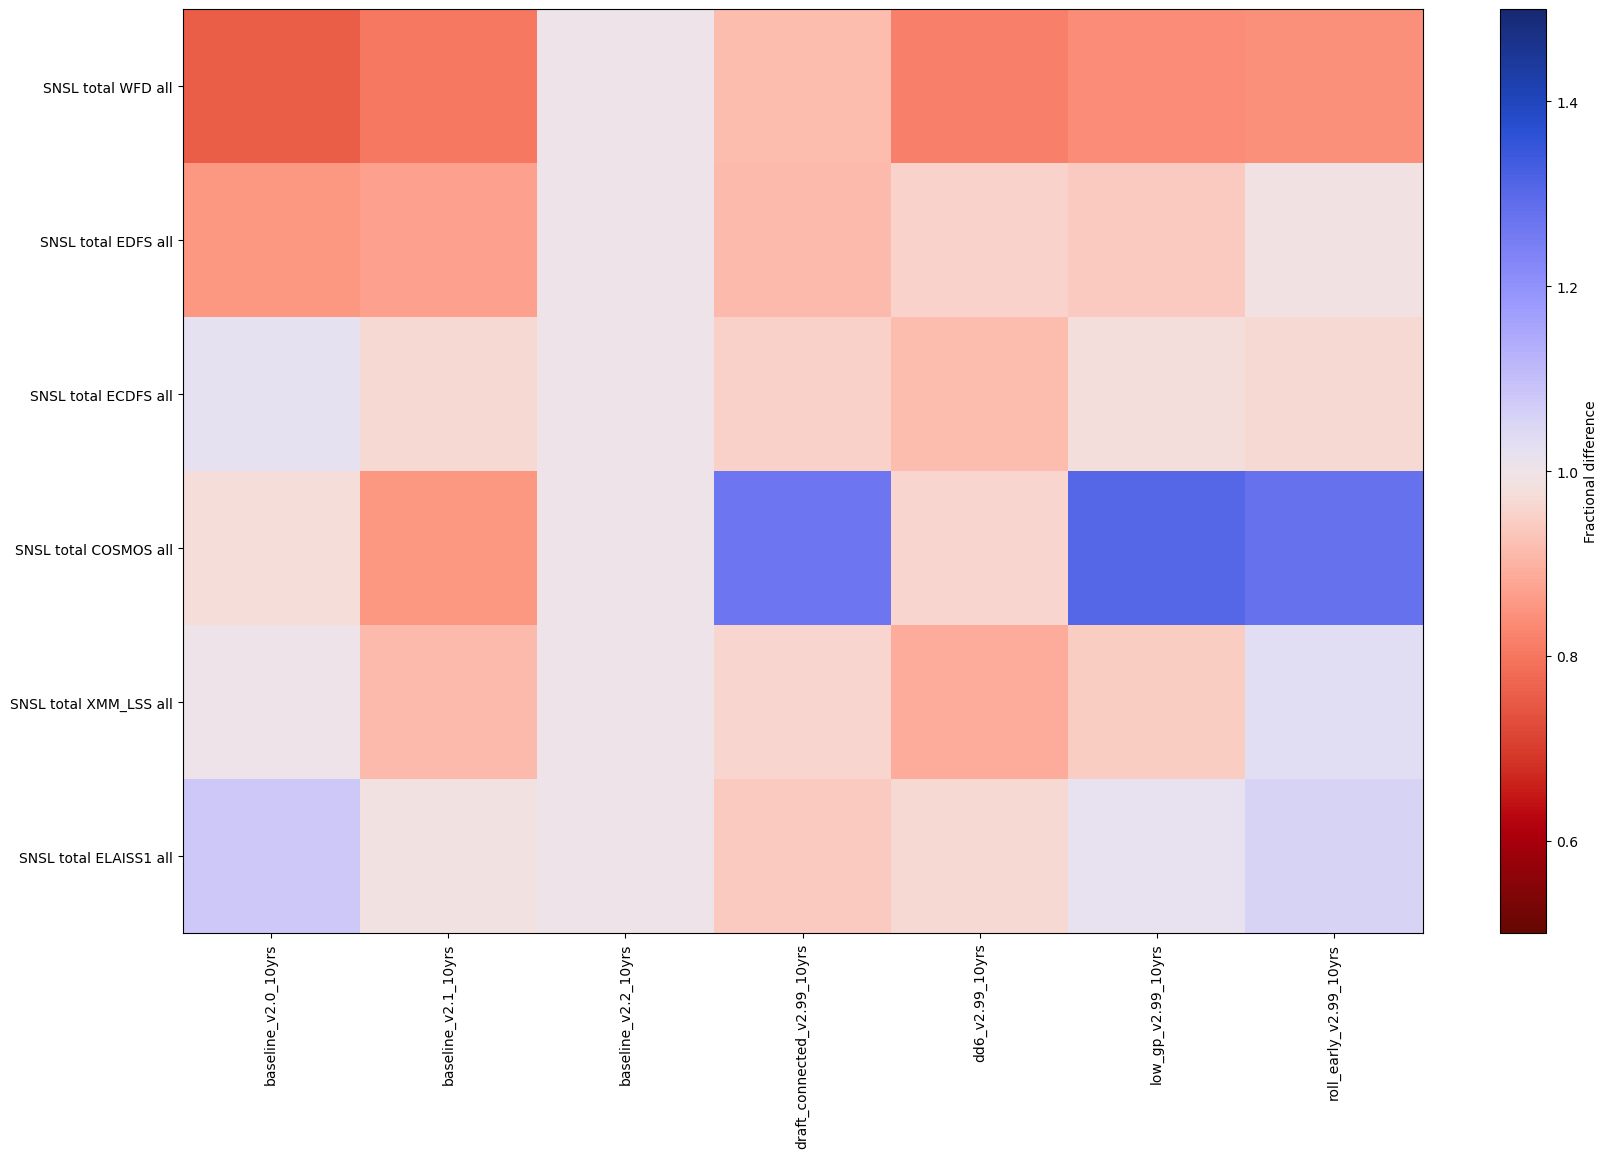

In [110]:
# The strong lensed SN are just very rare, so they show slight changes here but the actual values are likely
# equivalent 
for m in ['SNSL DDF']:
    metrics = metric_sets.loc[m]
    fig, ax = maf.plot_run_metric_mesh(summaries.loc[these_runs, metrics['metric']],
                                      baseline_run=baseline,
                                      metric_label_map=metrics['short_name'],
                                      metric_set=metrics, 
                                      color_range=1)
    fig.set_figwidth(20)
    fig.set_figheight(12)
    
summaries.loc[these_runs, metric_sets.loc['SNSL DDF']['metric']]